## Within-questionnaire slope model

In [1]:
import glob
import re
from nilearn.glm.second_level import SecondLevelModel
import pandas as pd
import nibabel as nf

In [10]:
root = '/oak/stanford/groups/russpold/data/uh2/aim1'
activation_map_path = f'{root}/derivatives/output_surveyMedley_noderivs_rerun/surveyMedley_lev1_output/task_surveyMedley_rtmodel_rt_duration/contrast_estimates'
activation_maps = glob.glob(f'{activation_map_path}/*')

sub_ids = sorted(
    set(
        [
            re.search('_sub_(.*)_rtmodel_rt_duration_stat_contrast.nii.gz', val).group(
                1
            )
            for val in activation_maps
        ]
    )
)
# exclude the subjects who contribute to the most dropout in the group mask (this was determined earlier by Jeanette)
excluded_subject_ids = ['234', '445']
sub_ids = [sub for sub in sub_ids if sub not in excluded_subject_ids]

# Load events files
events_files = sorted(
    glob.glob(f'{root}/BIDS/sub-s*/ses-[0-9]/func/*surveyMedley*modified*.tsv')
)

grit_questions = ['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08']
brief_questions = [
    'Q09',
    'Q10',
    'Q11',
    'Q12',
    'Q13',
    'Q14',
    'Q15',
    'Q16',
    'Q17',
    'Q18',
    'Q19',
    'Q20',
    'Q21',
]
future_time_questions = [
    'Q22',
    'Q23',
    'Q24',
    'Q25',
    'Q26',
    'Q27',
    'Q28',
    'Q29',
    'Q30',
    'Q31',
]
upps_questions = ['Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37']
impulsive_venture_questions = ['Q38', 'Q39', 'Q40']
questionnaires = {
    'grit': grit_questions,
    'brief': brief_questions,
    'future_time': future_time_questions,
    'upps': upps_questions,
    'impulsive_venture': impulsive_venture_questions,
}

In [3]:
def get_sub_event_file(sub_id, events_files):
    for file in events_files:
        if sub_id in file:
            return file

In [5]:
# for sub in sub_ids:
#     sub_event_file = get_sub_event_file(sub, events_files)
#     df = pd.read_csv(sub_event_file, sep='\t')
#     # Get behavioral and bold data for each questionnaire
#     behavior_dict = {
#         'grit': [],
#         'brief': [],
#         'future_time': [],
#         'upps': [],
#         'impulsive_venture': [],
#     }
#     bold_dict = {
#         'grit': [],
#         'brief': [],
#         'future_time': [],
#         'upps': [],
#         'impulsive_venture': [],
#     }
#     num_responses = 0
#     for questionnaire in questionnaires:
#         for question in questionnaires[questionnaire]:
#             response = df.loc[df['trial_type'] == question, 'coded_response']
#             behavior = response.values[0]
#             if not pd.isna(behavior):
#                 question_bold_file = f'{activation_map_path}/task_surveyMedley_contrast_{question}_v_baseline_sub_{sub}_rtmodel_rt_duration_stat_contrast.nii.gz'
#                 if question_bold_file in activation_maps:
#                     bold_dict[questionnaire].append(question_bold_file)
#                     behavior_dict[questionnaire].append(behavior)
#                     num_responses += 1
#     # Make design matrix
#     design_matrix = pd.DataFrame()
#     # First columns are dummy regressors for each questionnaire with 3 or more responses
#     start = 0
#     for questionnaire in questionnaires:
#         if len(behavior_dict[questionnaire]) >= 3:
#             one_indices = list(range(start, len(behavior_dict[questionnaire]) + start))
#             start = one_indices[-1] + 1
#             col = [1 if i in one_indices else 0 for i in range(num_responses)]
#             design_matrix[questionnaire] = col
#     # Other columns are questionnaire-specific behavioral regressors
#     start = 0
#     for questionnaire in questionnaires:
#         if len(behavior_dict[questionnaire]) >= 3:
#             one_indices = list(range(start, len(behavior_dict[questionnaire]) + start))
#             start = one_indices[-1] + 1
#             col = [
#                 behavior_dict[questionnaire][i - one_indices[0]]
#                 if i in one_indices
#                 else 0
#                 for i in range(num_responses)
#             ]
#             design_matrix[f'{questionnaire}_responses'] = col
#     all_zeros_rows_count = (design_matrix == 0).all(axis=1).sum()
#     design_matrix = design_matrix.loc[(design_matrix != 0).any(axis=1)]
#     for i in range(all_zeros_rows_count):
#         bold_dict['impulsive_venture'].pop(-1)

#     # generate a contrast map for each questionnaire
#     model = SecondLevelModel(n_jobs=2)
#     sub_bold_files = []
#     for questionnaire in questionnaires:
#         sub_bold_files = sub_bold_files + bold_dict[questionnaire]
#     model.fit(sub_bold_files, design_matrix=design_matrix)
#     for i in range(int(design_matrix.shape[1] / 2)):
#         contrast_map = model.compute_contrast(
#             second_level_contrast=design_matrix.columns[i], output_type='effect_size'
#         )
#         nf.save(
#             contrast_map,
#             f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/{design_matrix.columns[i]}_behavioral_measures_effect_size_sub_{sub}.nii.gz',
#         )

## Group analysis

In [4]:
from randomise_prep import setup_randomise_tfce
from nilearn import masking
from nilearn.plotting import plot_design_matrix

In [5]:
outlier_file = pd.read_csv(
    f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/behavioral_measures_effect_size_outlier_analysis/percent_outlier_data.csv'
)

contrast_estimates = []
estimates_per_subject = {}  # keep track of which questionnaire contrasts each subject has
subjects_to_remove = []  # we will remove subjects with no, or outlying, grit contrast, as this is our baseline questionnaire
for sub_id in sub_ids:
    sub_contrast_estimates = glob.glob(
        f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/*behavioral_measures_effect_size_sub_{sub_id}*'
    )
    estimates_per_subject[sub_id] = []
    for questionnaire in questionnaires:
        contrast_present = False
        filename = f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/{questionnaire}_behavioral_measures_effect_size_sub_{sub_id}.nii.gz'
        if filename in sub_contrast_estimates:
            # don't include contrast estimates past the outlier threshold: > 8% voxels above +/- 3SD above subject-specific mean
            condition = (outlier_file['subject_label'] == int(sub_id)) & (
                outlier_file['contrast_name'] == questionnaire
            )
            outlier_percentage = outlier_file.loc[
                condition, 'image_outlier_percentage'
            ].iloc[0]
            if outlier_percentage > 8:
                if questionnaire == 'grit':
                    subjects_to_remove.append(sub_id)
                    break
            else:
                contrast_estimates.append(filename)
                contrast_present = True
        estimates_per_subject[sub_id].append(contrast_present)
sub_ids = [sub for sub in sub_ids if sub not in subjects_to_remove]

In [11]:
questionnaires

{'grit': ['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08'],
 'brief': ['Q09',
  'Q10',
  'Q11',
  'Q12',
  'Q13',
  'Q14',
  'Q15',
  'Q16',
  'Q17',
  'Q18',
  'Q19',
  'Q20',
  'Q21'],
 'future_time': ['Q22',
  'Q23',
  'Q24',
  'Q25',
  'Q26',
  'Q27',
  'Q28',
  'Q29',
  'Q30',
  'Q31'],
 'upps': ['Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37'],
 'impulsive_venture': ['Q38', 'Q39', 'Q40']}

In [14]:
from glob import glob

# This will include subjects who are outliers, so be sure to use subids to filter out
within_sub_slope_paths = glob(
    '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/*behavioral_measures_effect_size_sub*nii.gz'
)

In [22]:
import os
import itertools
import warnings

import numpy as np
import nibabel as nib
from nilearn.glm.second_level import SecondLevelModel


def run_paired_wholebrain_tests(
    sub_ids, within_sub_slope_paths, questionnaires, outdir, min_subjects=2
):
    """
    Run paired whole-brain tests for every pair of questionnaires.

    Parameters
    ----------
    sub_ids : list[str]
        List of subject id substrings to look for in file paths.
    within_sub_slope_paths : list[str]
        Paths to nifti files. Each path should include both a subject id substring
        and a questionnaire name substring (keys of `questionnaires`).
    questionnaires : dict-like
        Mapping whose keys are the 5 questionnaire names (strings). Only the keys are used.
    outdir : str
        Directory to save zstat maps. Filenames will be:
            outdir/paired_test_{q1}_minus_{q2}.nii.gz
    min_subjects : int
        Minimum number of subjects required to run a test for a pair (default 2).
    """

    os.makedirs(outdir, exist_ok=True)
    qnames = list(questionnaires.keys())

    # Pre-normalize path list to str for safer matching
    paths = [str(p) for p in within_sub_slope_paths]

    for q1, q2 in itertools.combinations(qnames, 2):
        print(f'\nProcessing pair: {q1}  vs  {q2}')

        q1_paths = []
        q2_paths = []
        matched_subs = []

        # For each subject, try to find exactly one match for each questionnaire.
        for sub in sub_ids:
            # look for paths containing both sub substring and questionnaire substring
            matches_q1 = [p for p in paths if (q1 in p) and (sub in p)]
            matches_q2 = [p for p in paths if (q2 in p) and (sub in p)]

            if len(matches_q1) == 0 or len(matches_q2) == 0:
                # subject doesn't have both files -> skip
                continue

            if len(matches_q1) > 1 or len(matches_q2) > 1:
                # multiple matches for either; you may want to refine search or choose first
                warnings.warn(
                    f'Subject {sub} has multiple matches for {q1} or {q2}. '
                    f'Using the first match for each. (q1_matches={len(matches_q1)}, q2_matches={len(matches_q2)})'
                )

            q1_paths.append(matches_q1[0])
            q2_paths.append(matches_q2[0])
            matched_subs.append(sub)

        nsub = len(matched_subs)
        print(f'  matched subjects with both: {nsub}')

        if nsub < min_subjects:
            print(f'  Not enough subjects ({nsub}) for pair {q1} vs {q2}. Skipping.')
            continue

        # Build per-subject difference images in memory (q1 - q2)
        diff_imgs = []
        skipped = 0
        for p1, p2, sub in zip(q1_paths, q2_paths, matched_subs):
            img1 = nib.load(p1)
            img2 = nib.load(p2)

            # Basic alignment/compatibility checks
            if img1.shape != img2.shape:
                warnings.warn(
                    f'Shape mismatch for subject {sub}: {p1} vs {p2}. Skipping subject.'
                )
                skipped += 1
                continue
            if not np.allclose(img1.affine, img2.affine):
                warnings.warn(
                    f'Affine mismatch for subject {sub}: {p1} vs {p2}. Skipping subject.'
                )
                skipped += 1
                continue

            data1 = img1.get_fdata(dtype=np.float32)
            data2 = img2.get_fdata(dtype=np.float32)

            # Compute difference image (q1 - q2)
            diff_data = data1 - data2

            # Build a nibabel image with the same affine/header as img1
            diff_img = nib.Nifti1Image(diff_data, img1.affine, img1.header)
            diff_imgs.append(diff_img)

        effective_n = len(diff_imgs)
        if effective_n < min_subjects:
            print(
                f'  After skipping mismatches, only {effective_n} subjects remain. Skipping pair.'
            )
            continue

        print(
            f'  Running second-level one-sample t-test on {effective_n} difference images...'
        )
        design_matrix = pd.DataFrame(
            [1] * effective_n,
            columns=['intercept'],
        )
        # Fit a one-sample test (i.e., test whether mean difference != 0)
        slm = SecondLevelModel()
        # slm.fit accepts a list of 3D images (nib objects OK)
        slm = slm.fit(
            diff_imgs, design_matrix=design_matrix
        )  # design matrix omitted -> intercept only

        z_map = slm.compute_contrast(
            second_level_contrast='intercept',
            output_type='z_score',
        )

        out_fname = os.path.join(outdir, f'paired_test_{q1}_minus_{q2}.nii.gz')
        nib.save(z_map, out_fname)
        print(
            f'  Saved zstat: {out_fname} (from {effective_n} subjects, skipped {skipped})'
        )

    print('\nAll pairs processed.')

In [19]:
outdir = '/home/users/jmumford/test_paired_slopes'

In [23]:
run_paired_wholebrain_tests(
    sub_ids=sub_ids,
    within_sub_slope_paths=within_sub_slope_paths,
    questionnaires=questionnaires,
    outdir=outdir,
)


Processing pair: grit  vs  brief
  matched subjects with both: 93
  Running second-level one-sample t-test on 93 difference images...
  Saved zstat: /home/users/jmumford/test_paired_slopes/paired_test_grit_minus_brief.nii.gz (from 93 subjects, skipped 0)

Processing pair: grit  vs  future_time
  matched subjects with both: 93
  Running second-level one-sample t-test on 93 difference images...
  Saved zstat: /home/users/jmumford/test_paired_slopes/paired_test_grit_minus_future_time.nii.gz (from 93 subjects, skipped 0)

Processing pair: grit  vs  upps
  matched subjects with both: 93
  Running second-level one-sample t-test on 93 difference images...
  Saved zstat: /home/users/jmumford/test_paired_slopes/paired_test_grit_minus_upps.nii.gz (from 93 subjects, skipped 0)

Processing pair: grit  vs  impulsive_venture
  matched subjects with both: 65
  Running second-level one-sample t-test on 65 difference images...
  Saved zstat: /home/users/jmumford/test_paired_slopes/paired_test_grit_min

In [24]:
f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/group_mask.nii.gz'

'/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/group_mask.nii.gz'

In [7]:
# apply easythresh

import subprocess
from pathlib import Path
import shutil


def run_easythresh(input_filename: str):
    """
    Run easythresh on a zstat map for both positive and negative thresholds,
    storing output in easythresh/ and copying the main thresholded map to root_dir.

    Parameters
    ----------
    input_filename : str
        Base name of the contrast (without .nii.gz), e.g., 'paired_test_brief_minus_future_time'
    """
    root_dir = Path('/home/users/jmumford/test_paired_slopes')
    easythresh_dir = root_dir / 'easythresh'
    input_file = root_dir / f'{input_filename}.nii.gz'
    group_mask = easythresh_dir / 'group_mask.nii.gz'

    t_thresh = 3.1
    p_thresh = 0.01

    # -------------------------------
    # 1. Positive threshold
    # -------------------------------
    pos_prefix = f'{input_filename}_gt0'
    print(f'Running easythresh (positive) for {input_filename} -> {pos_prefix}')

    subprocess.run(
        [
            'easythresh',
            str(input_file),
            str(group_mask),
            str(t_thresh),
            str(p_thresh),
            str(group_mask),
            pos_prefix,
        ],
        cwd=str(easythresh_dir),
        check=True,
    )

    pos_thresh_file = easythresh_dir / f'thresh_{pos_prefix}.nii.gz'
    if pos_thresh_file.exists():
        # Copy main thresholded map to root_dir
        shutil.copy(pos_thresh_file, root_dir / pos_thresh_file.name)
        print(
            f'Positive threshold map saved in easythresh/ and copied to root_dir: {pos_thresh_file.name}'
        )
    else:
        print(f'No voxels survived positive threshold for {input_filename}')

    # -------------------------------
    # 2. Negative threshold
    # -------------------------------
    neg_prefix = f'{input_filename}_lt0'
    neg_file = easythresh_dir / f'neg_{input_filename}.nii.gz'
    print(f'Creating negative map for {input_filename} -> {neg_file.name}')

    subprocess.run(
        ['fslmaths', str(input_file), '-mul', '-1', str(neg_file)], check=True
    )

    print(f'Running easythresh (negative) for {input_filename} -> {neg_prefix}')
    subprocess.run(
        [
            'easythresh',
            str(neg_file),
            str(group_mask),
            str(t_thresh),
            str(p_thresh),
            str(group_mask),
            neg_prefix,
        ],
        cwd=str(easythresh_dir),
        check=True,
    )

    neg_thresh_file = easythresh_dir / f'thresh_{neg_prefix}.nii.gz'
    if neg_thresh_file.exists():
        # Copy main thresholded map to root_dir
        shutil.copy(neg_thresh_file, root_dir / neg_thresh_file.name)
        print(
            f'Negative threshold map saved in easythresh/ and copied to root_dir: {neg_thresh_file.name}'
        )
    else:
        print(f'No voxels survived negative threshold for {input_filename}')

    print('Done!\n')

In [8]:
filenames = [
    'paired_test_brief_minus_future_time',
    'paired_test_brief_minus_impulsive_venture',
    'paired_test_brief_minus_upps',
    'paired_test_future_time_minus_impulsive_venture',
    'paired_test_future_time_minus_upps',
    'paired_test_grit_minus_brief',
    'paired_test_grit_minus_future_time',
    'paired_test_grit_minus_impulsive_venture',
    'paired_test_grit_minus_upps',
    'paired_test_upps_minus_impulsive_venture',
]

for filename in filenames:
    print(filename)
    run_easythresh(filename)

paired_test_brief_minus_future_time
Running easythresh (positive) for paired_test_brief_minus_future_time -> paired_test_brief_minus_future_time_gt0
Positive threshold map saved in easythresh/ and copied to root_dir: thresh_paired_test_brief_minus_future_time_gt0.nii.gz
Creating negative map for paired_test_brief_minus_future_time -> neg_paired_test_brief_minus_future_time.nii.gz
Running easythresh (negative) for paired_test_brief_minus_future_time -> paired_test_brief_minus_future_time_lt0
Negative threshold map saved in easythresh/ and copied to root_dir: thresh_paired_test_brief_minus_future_time_lt0.nii.gz
Done!

paired_test_brief_minus_impulsive_venture
Running easythresh (positive) for paired_test_brief_minus_impulsive_venture -> paired_test_brief_minus_impulsive_venture_gt0
Positive threshold map saved in easythresh/ and copied to root_dir: thresh_paired_test_brief_minus_impulsive_venture_gt0.nii.gz
Creating negative map for paired_test_brief_minus_impulsive_venture -> neg_paire

/tmp/ipykernel_248271/71510183.py:49: UserWarning: empty mask
  plot_stat_map(


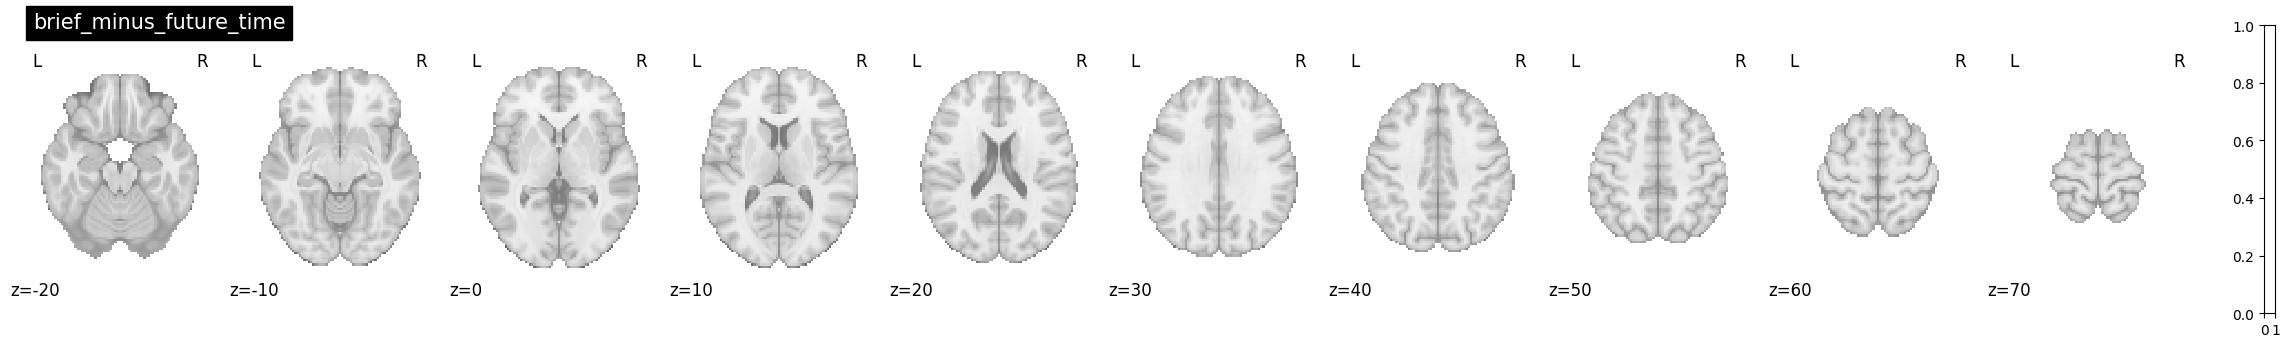

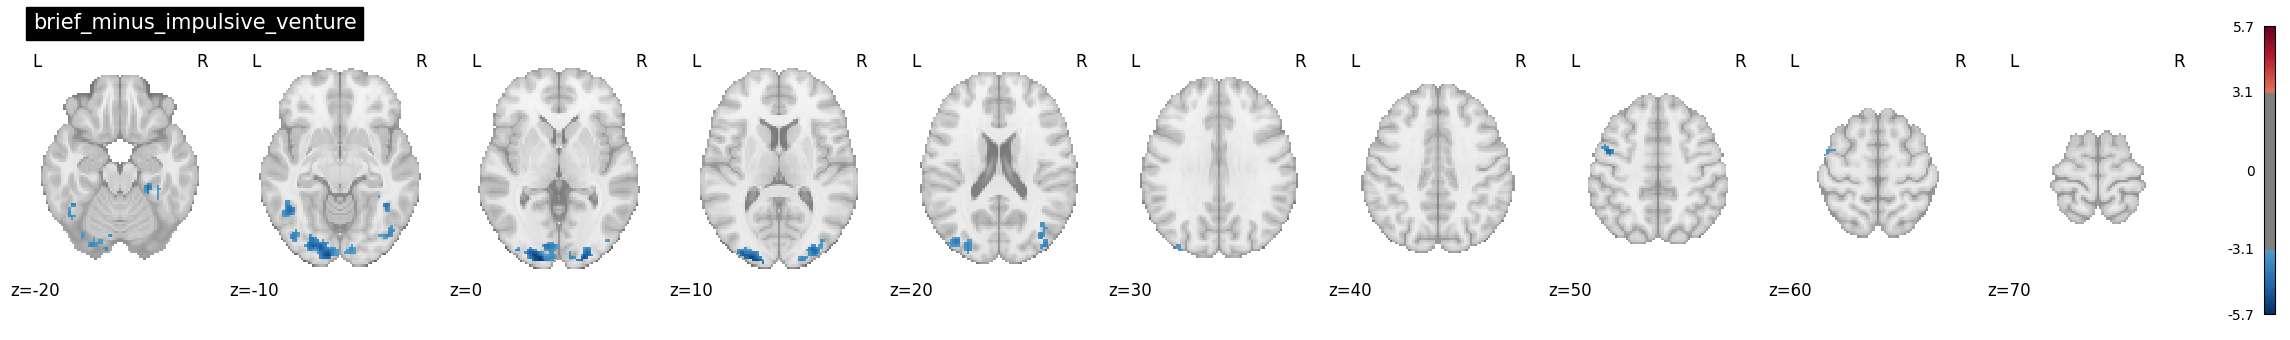

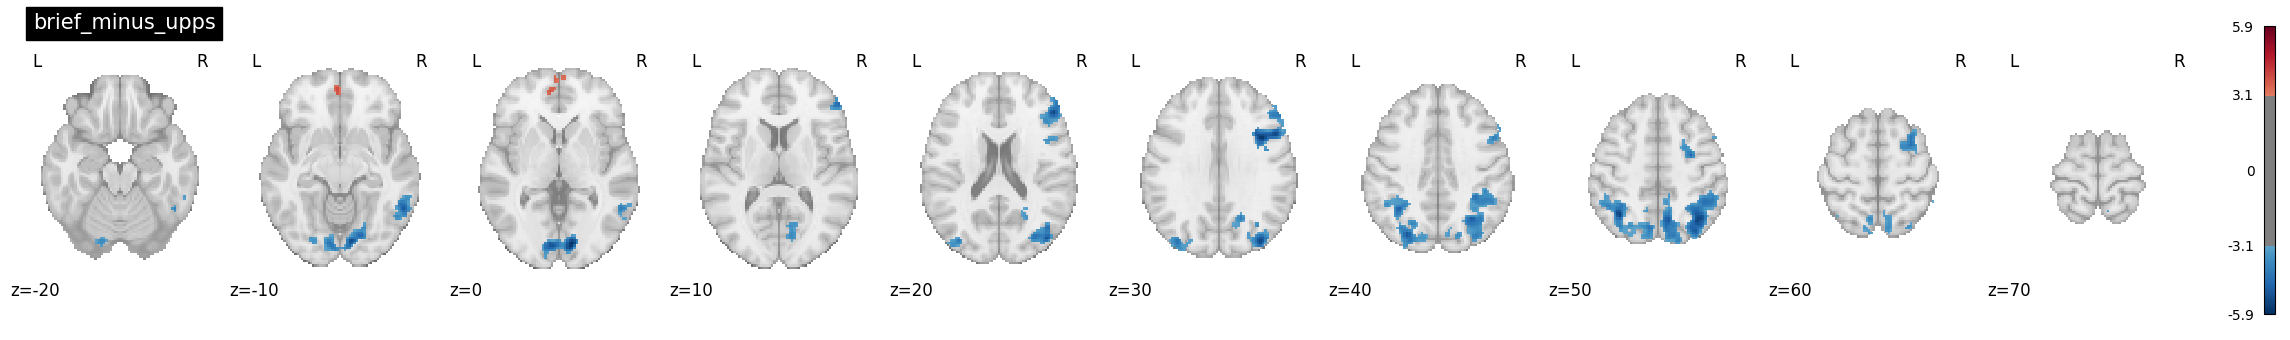

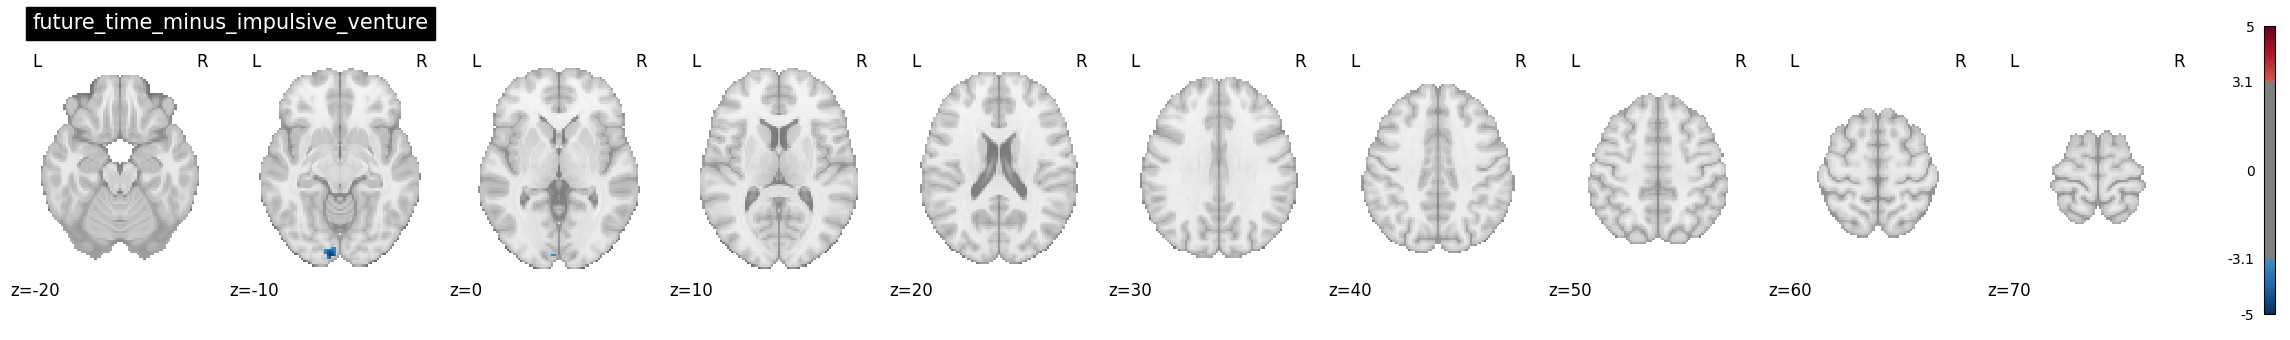

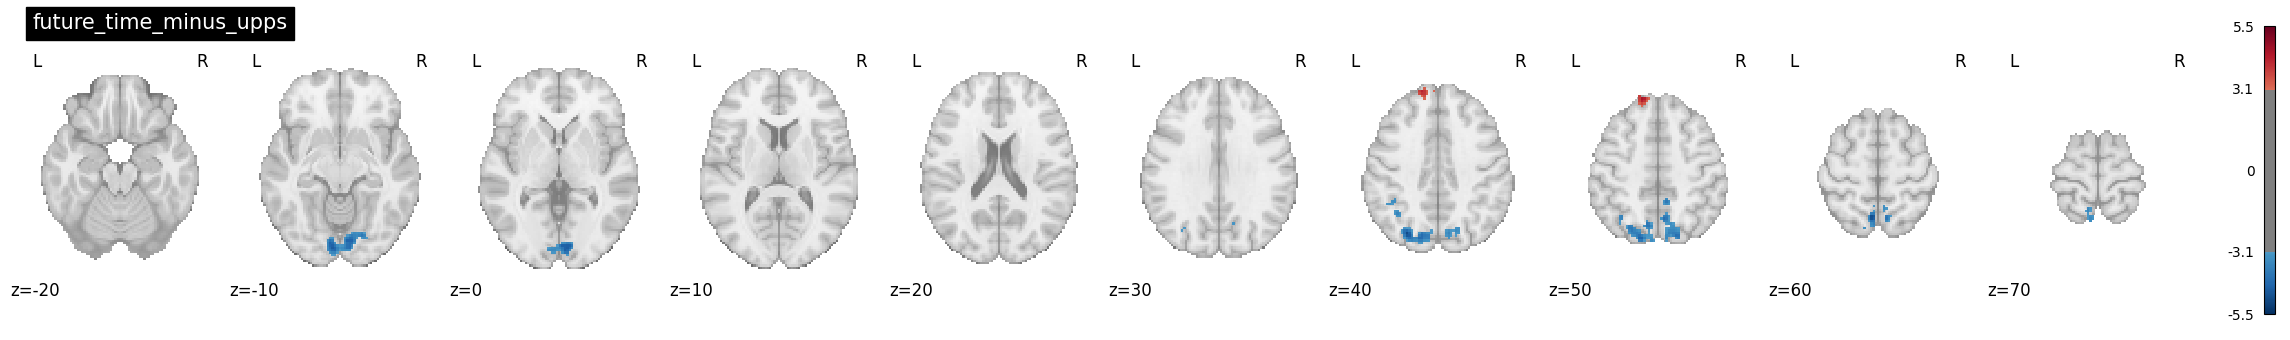

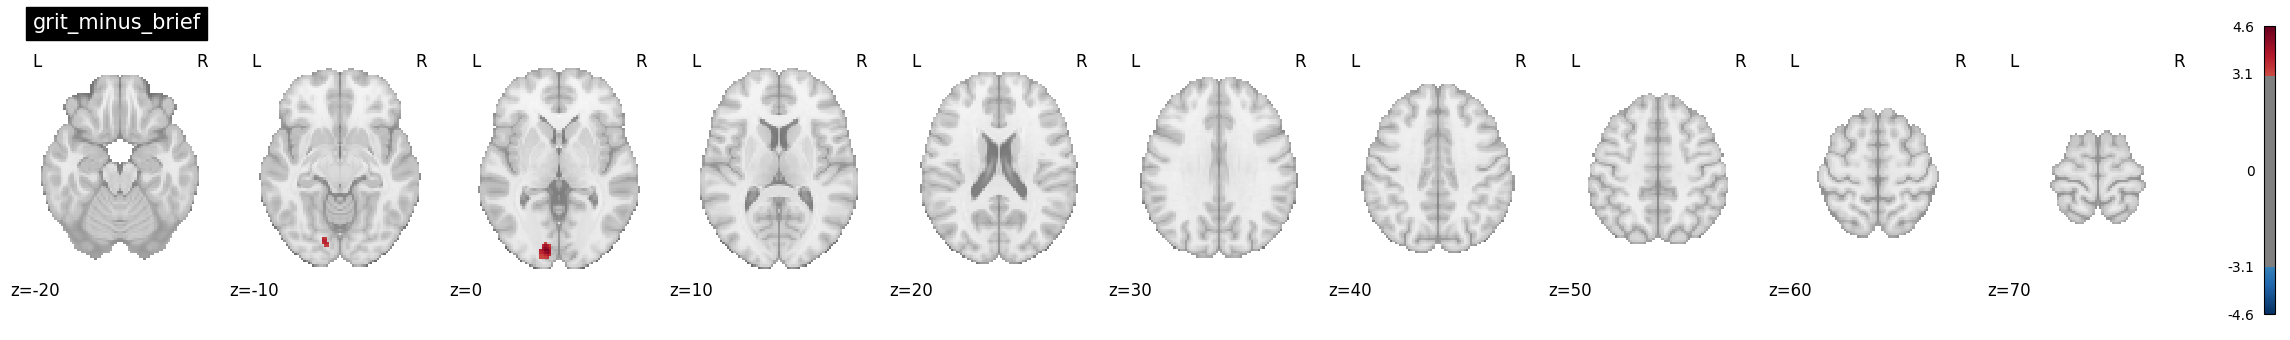

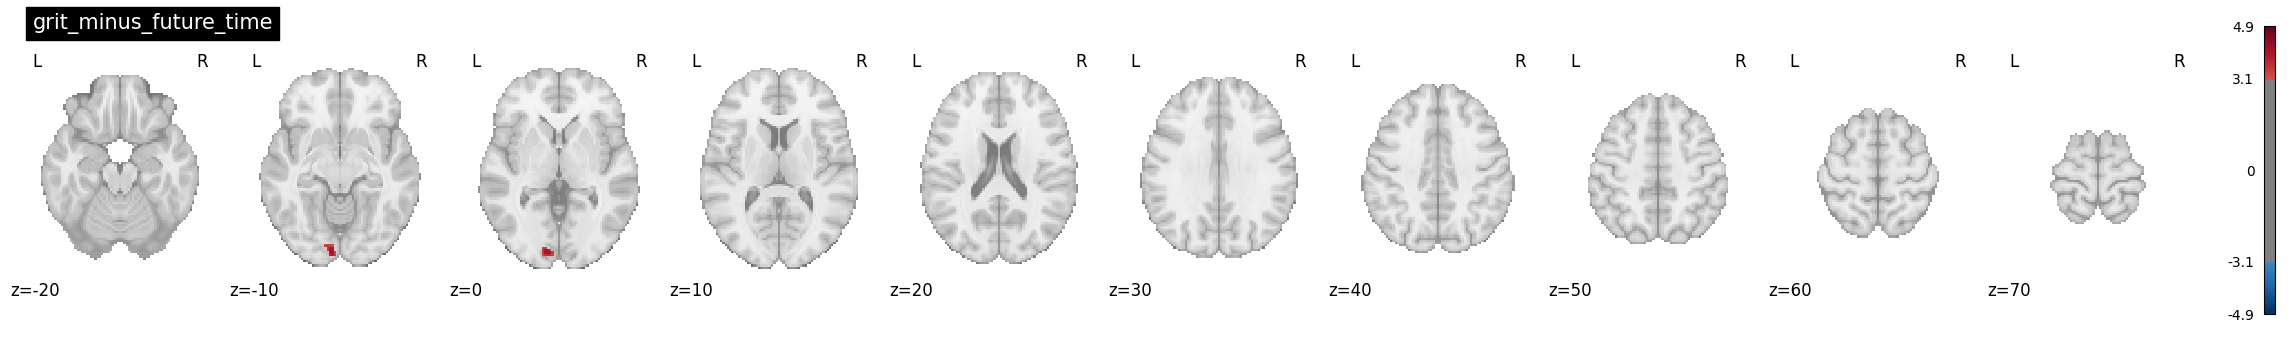

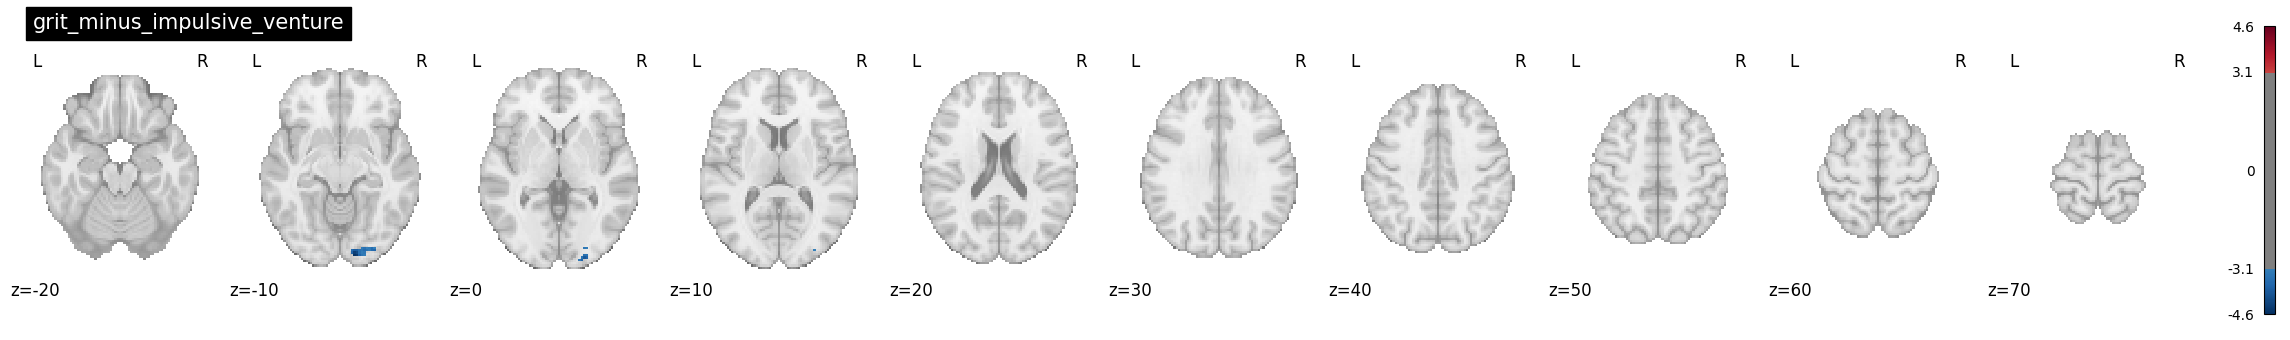

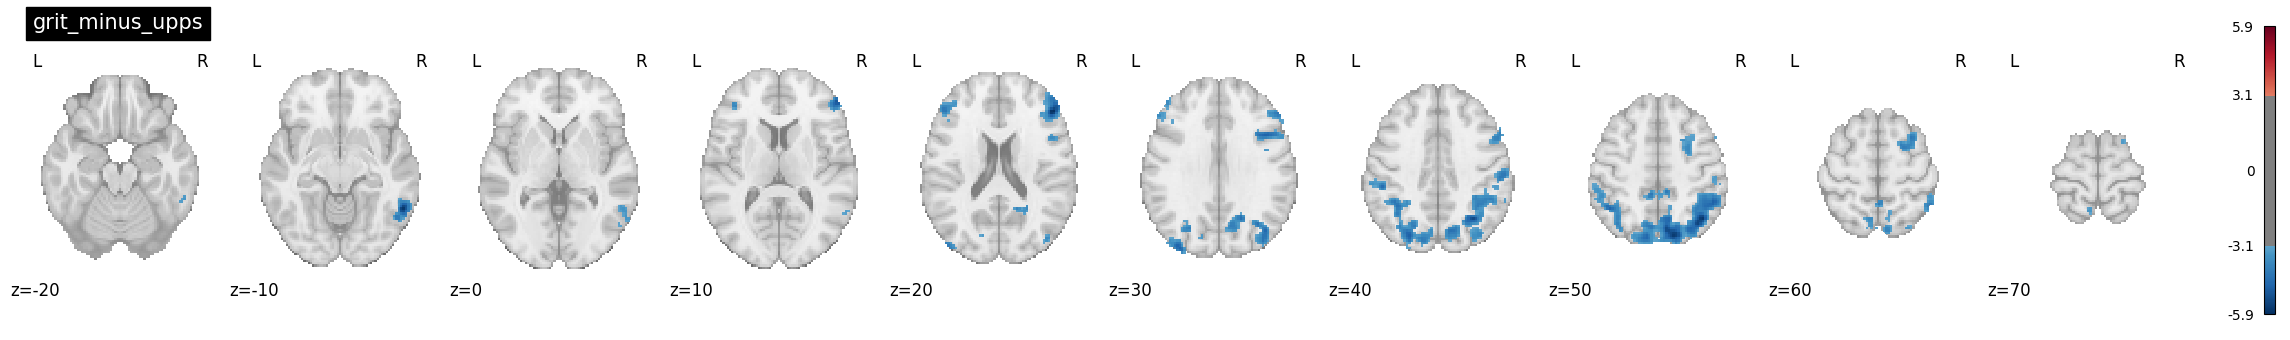

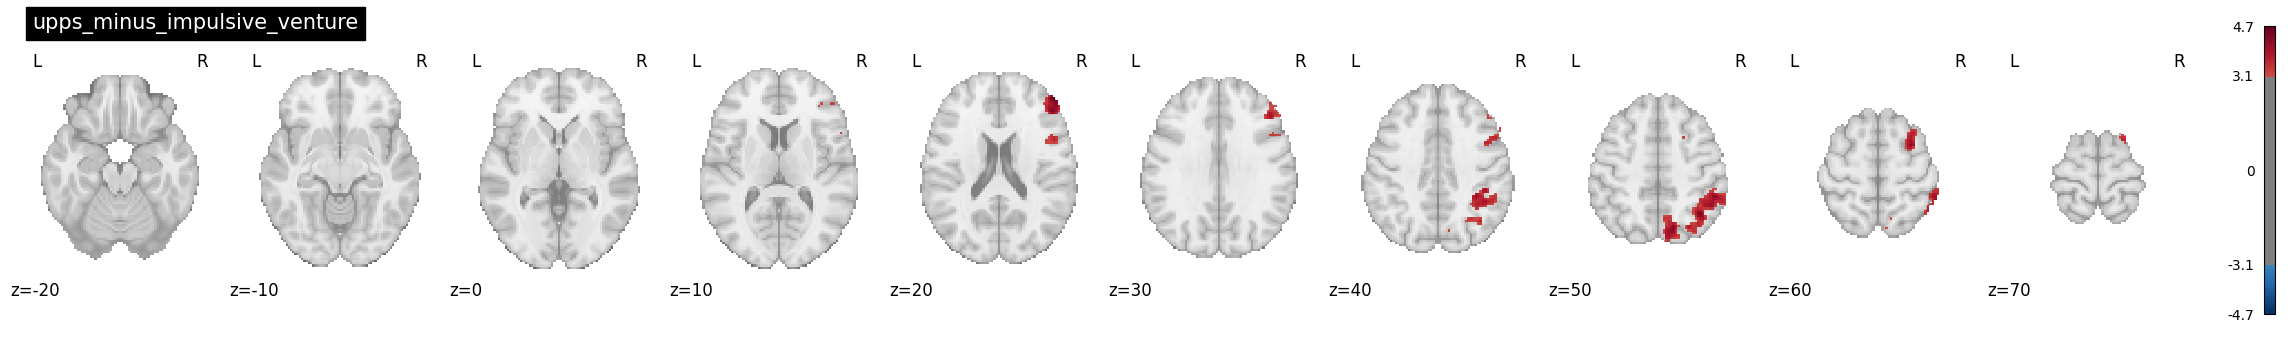

In [10]:
import numpy as np
from pathlib import Path
import nibabel as nib
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt

root_dir = Path('/home/users/jmumford/test_paired_slopes')

slices = np.arange(-20, 71, 10)

filenames = [
    'brief_minus_future_time',
    'brief_minus_impulsive_venture',
    'brief_minus_upps',
    'future_time_minus_impulsive_venture',
    'future_time_minus_upps',
    'grit_minus_brief',
    'grit_minus_future_time',
    'grit_minus_impulsive_venture',
    'grit_minus_upps',
    'upps_minus_impulsive_venture',
]
for fname in filenames:
    # Build expected paths
    thresh_lt0 = root_dir / f'thresh_paired_test_{fname}_lt0.nii.gz'
    thresh_gt0 = root_dir / f'thresh_paired_test_{fname}_gt0.nii.gz'
    zstat_file = root_dir / f'paired_test_{fname}.nii.gz'

    # Load original zstat
    z_img = nib.load(zstat_file)
    z_data = z_img.get_fdata()

    # Initialize mask sum
    mask_sum = np.zeros_like(z_data)

    # Binarize and sum thresholded maps if they exist
    for tfile in [thresh_lt0, thresh_gt0]:
        if tfile.exists():
            t_data = nib.load(tfile).get_fdata()
            mask_sum += (t_data > 0).astype(int)

    # Multiply original zstat by summed mask
    masked_z = z_data * mask_sum

    # Make a new Nifti image
    masked_img = nib.Nifti1Image(masked_z, affine=z_img.affine)

    # Plot slices in Z
    plot_stat_map(
        masked_img,
        display_mode='z',
        title=f'{fname}',
        cut_coords=slices,
        threshold=3.1,
        symmetric_cbar=True,
    )
    plt.show()

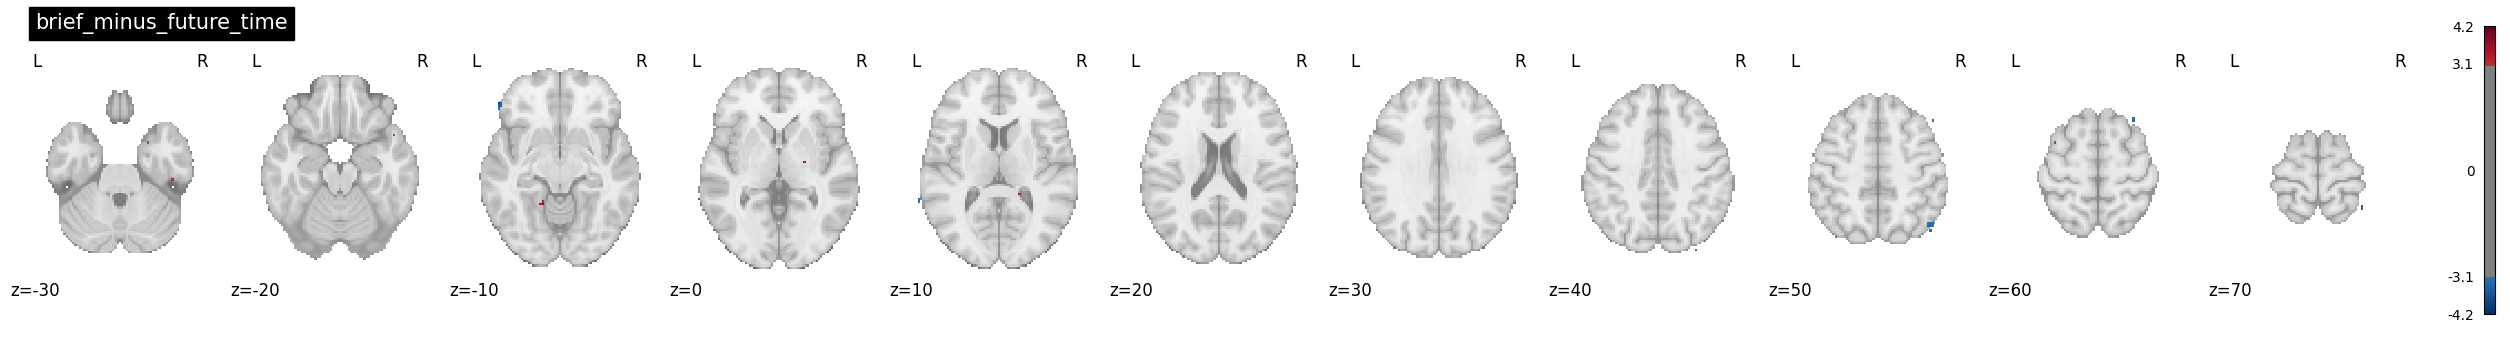

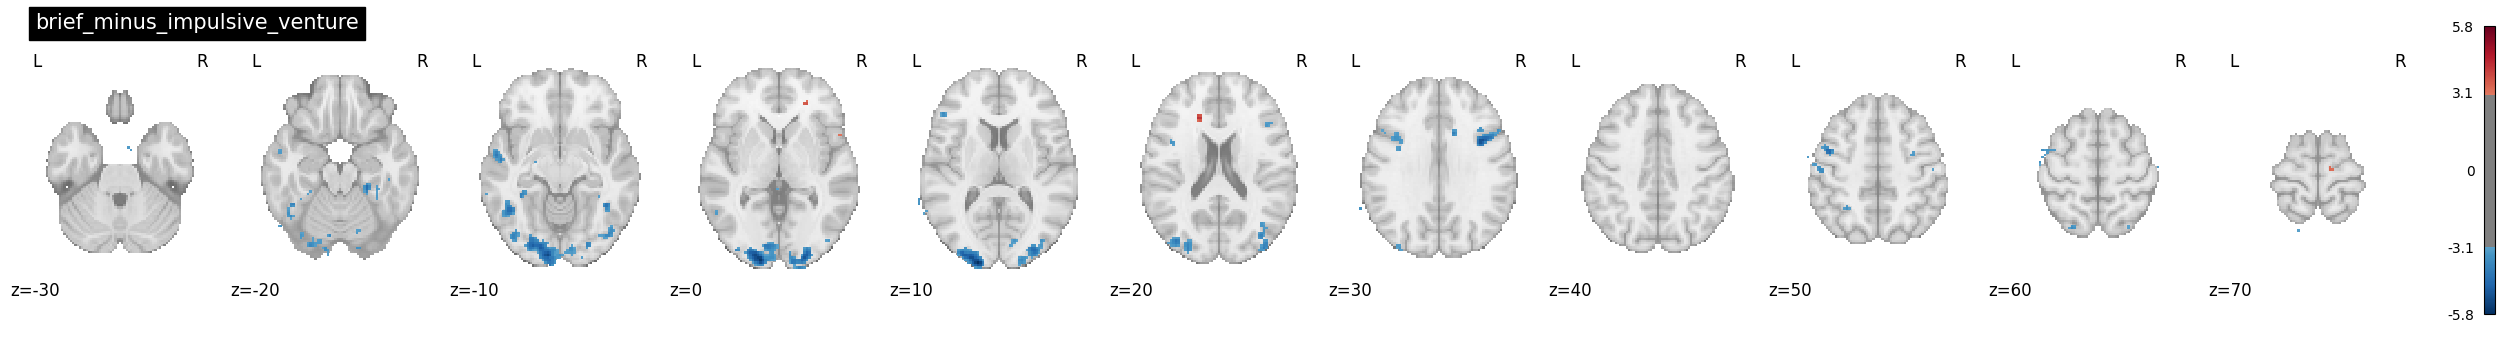

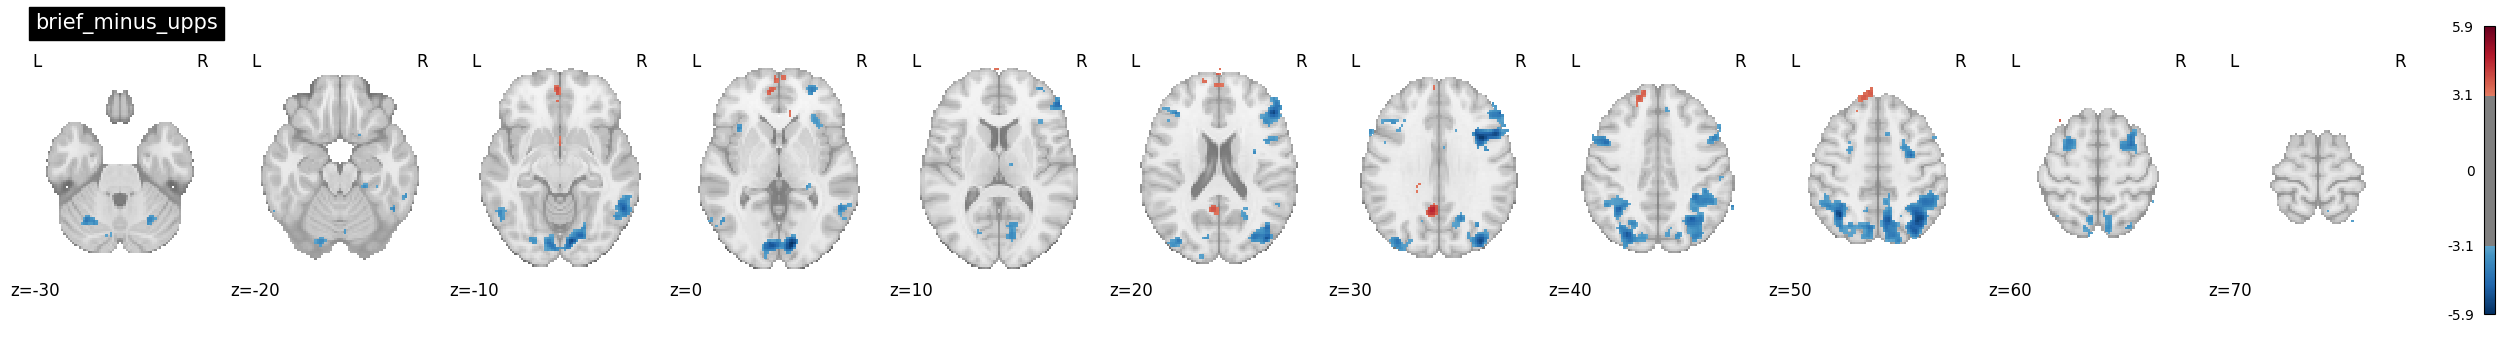

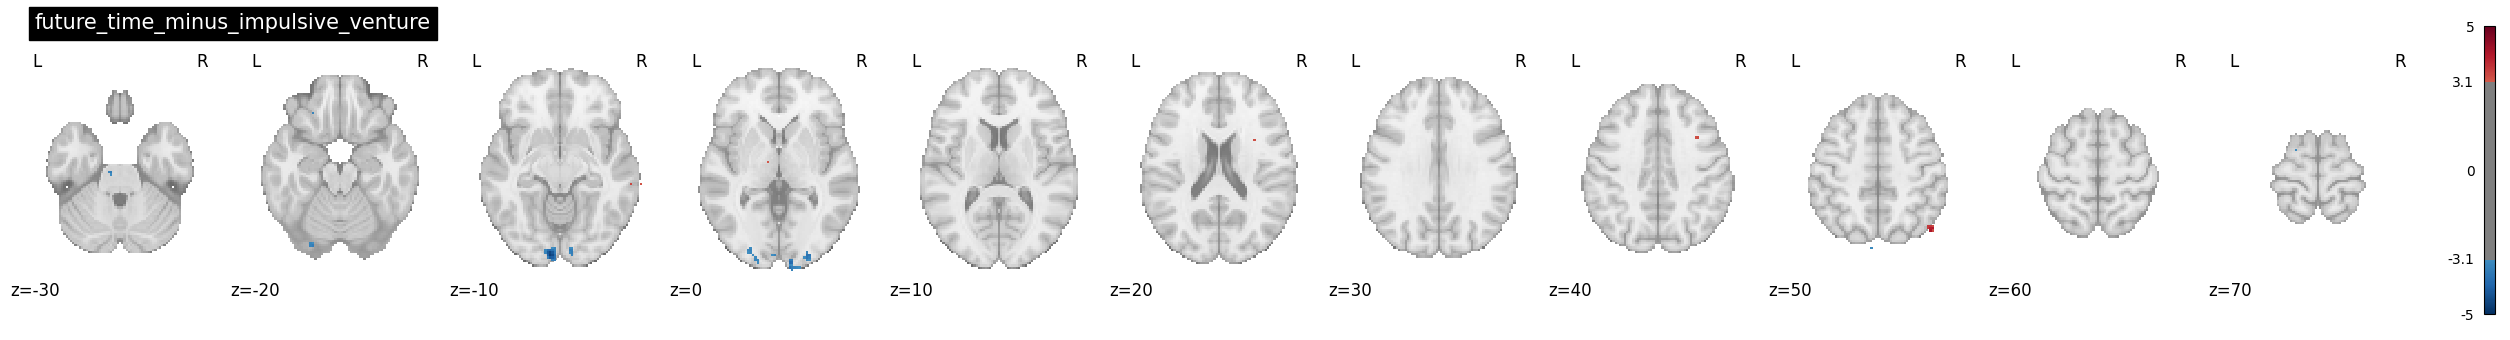

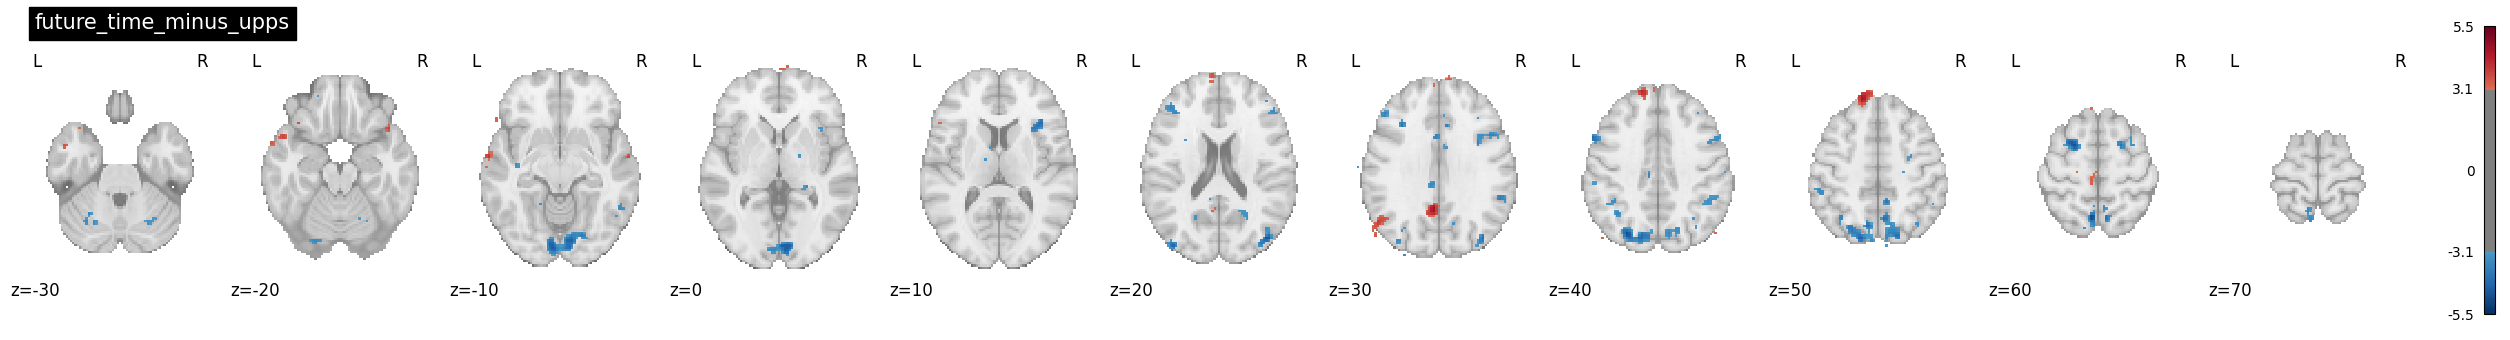

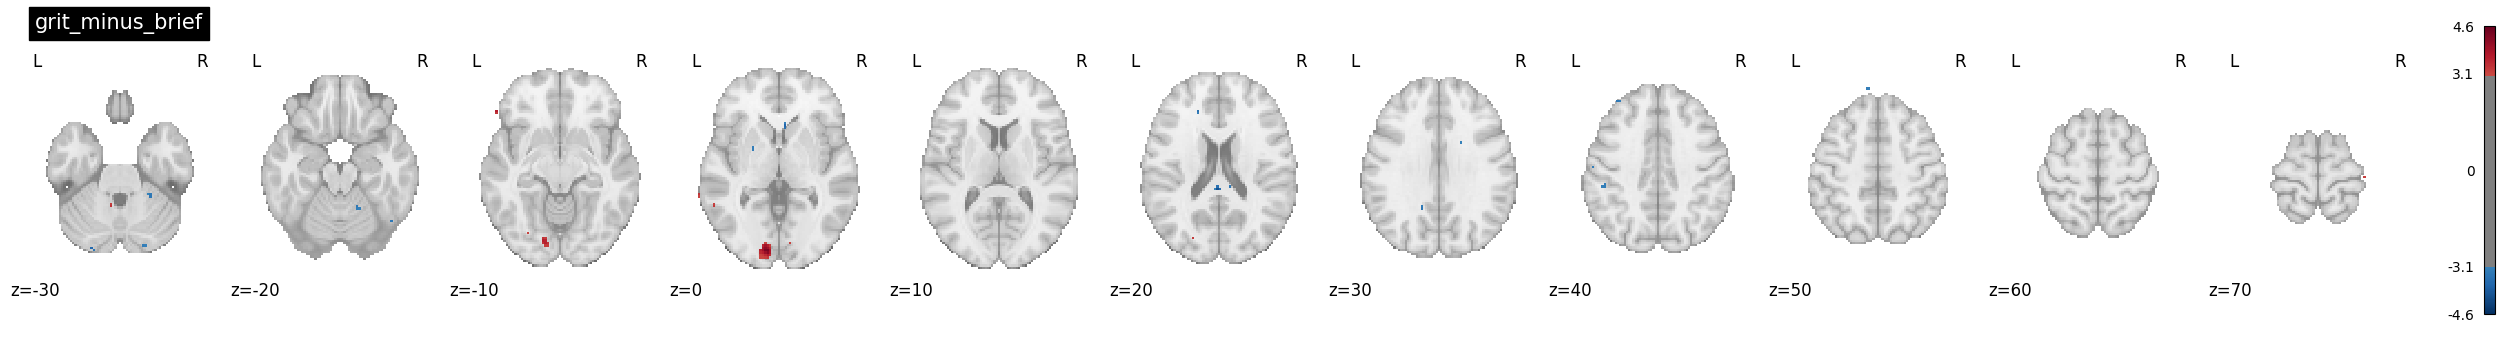

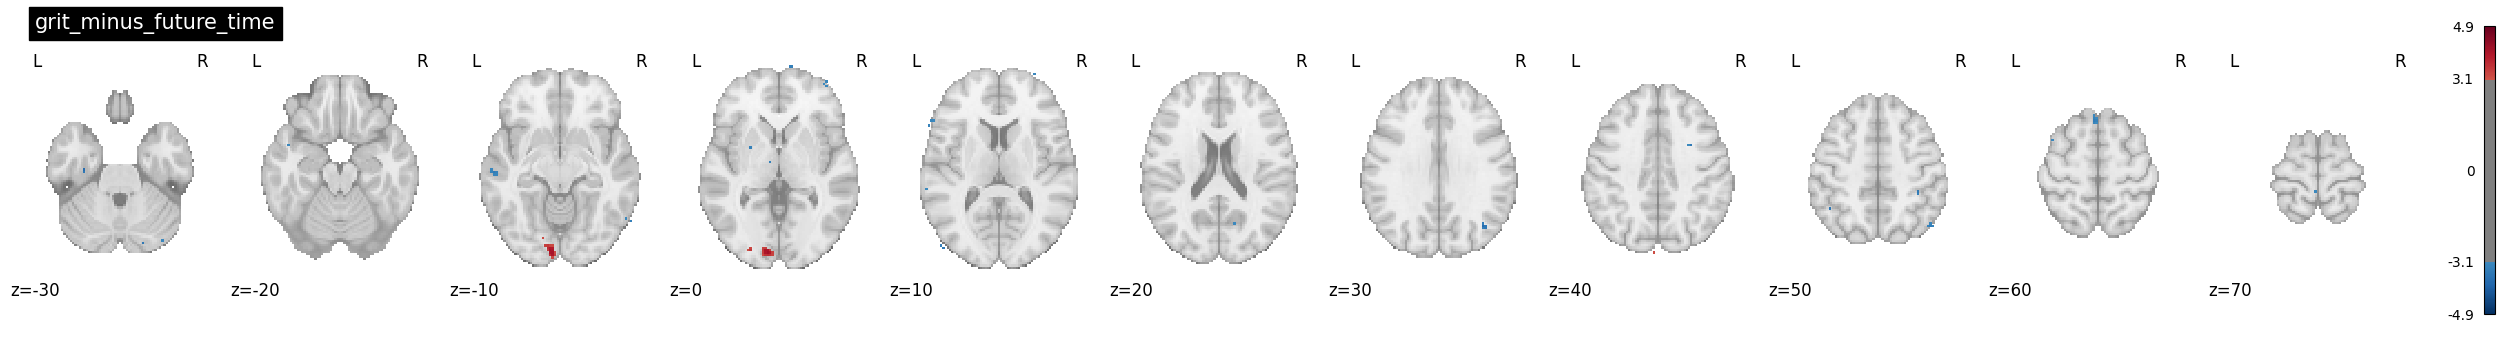

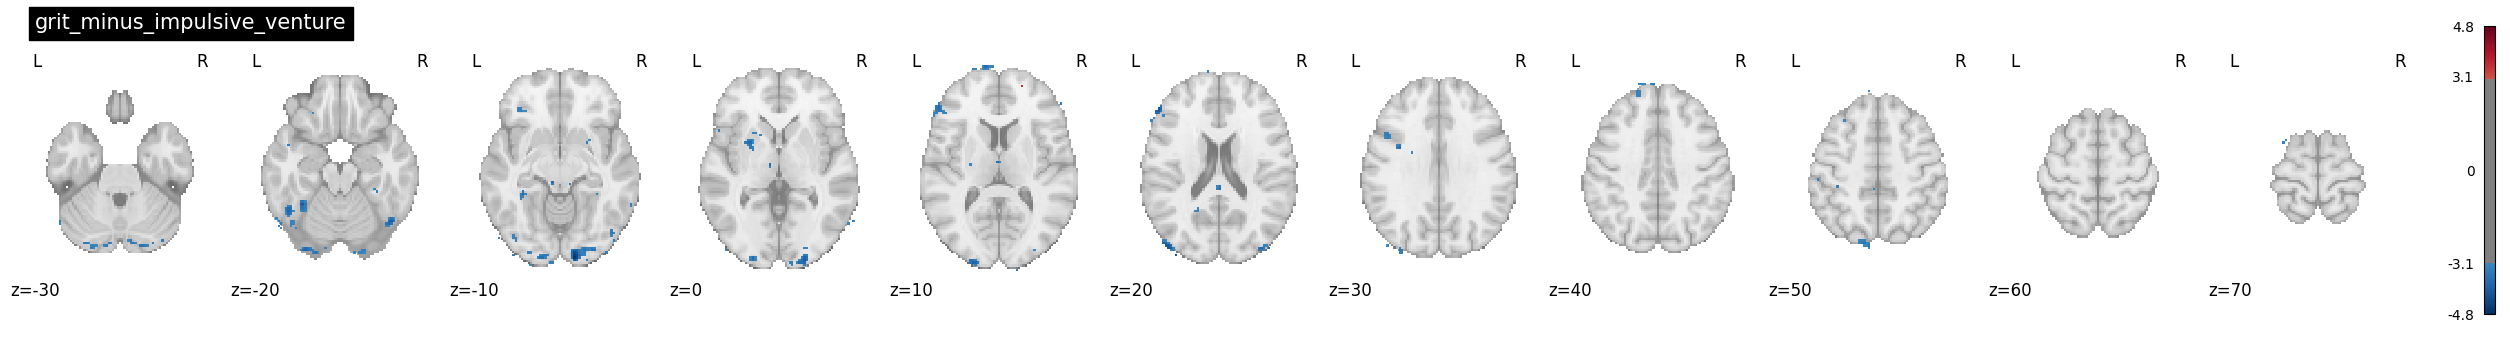

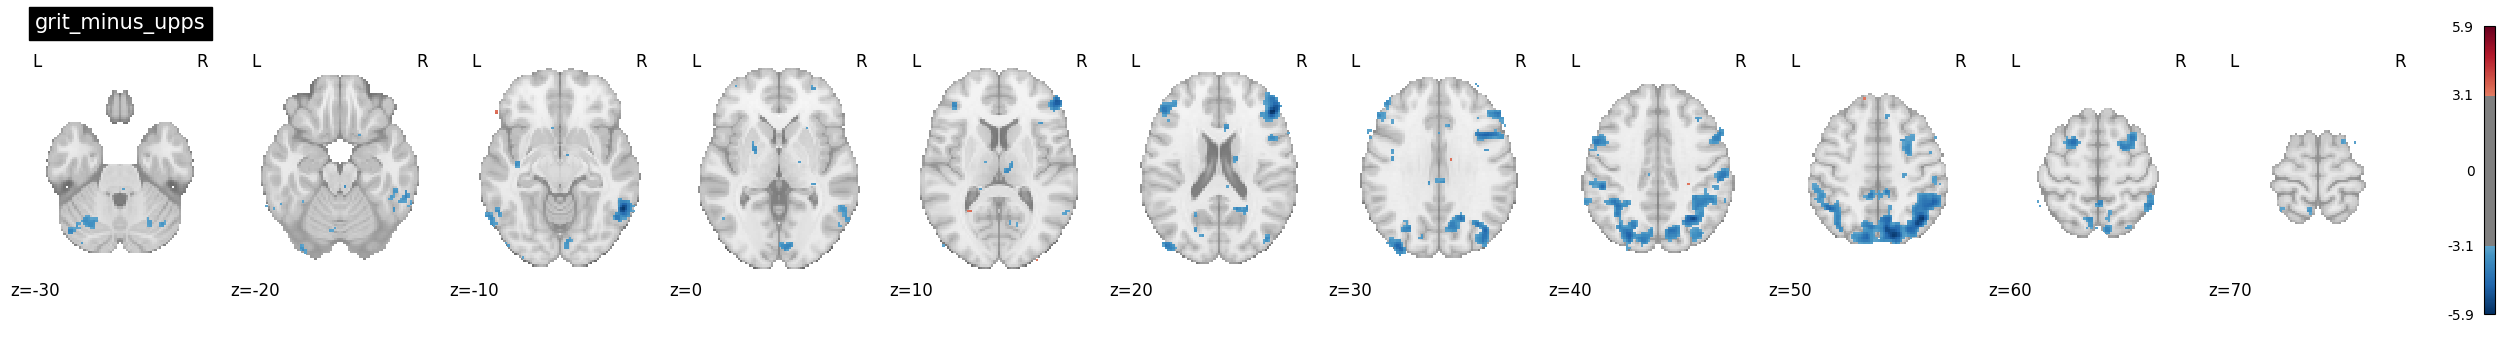

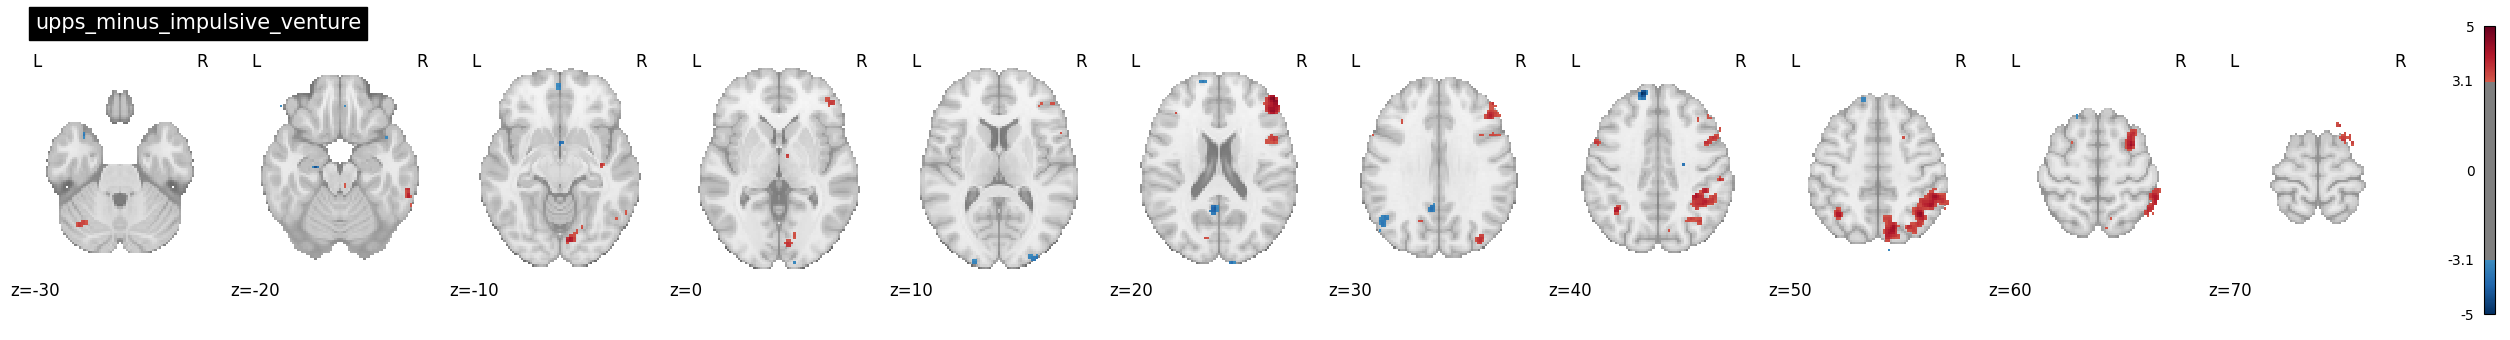

In [6]:
for fname in filenames:
    zstat_file = root_dir / f'paired_test_{fname}.nii.gz'
    # Plot slices in Z
    plot_stat_map(
        zstat_file, display_mode='z', title=f'{fname}', cut_coords=slices, threshold=3.1
    )
    plt.show()

In [30]:
print(len(sub_ids))
print(len(contrast_estimates))
estimates_per_subject

93
416


{'061': [],
 '130': [True, True, True, True, True],
 '172': [True, True, True, True, True],
 '192': [True, True, True, True, True],
 '251': [True, True, True, True, True],
 '358': [True, True, True, True, True],
 '373': [True, True, True, True, False],
 '465': [True, True, True, True, True],
 '483': [True, True, False, True, True],
 '491': [True, True, True, True, True],
 '495': [True, True, True, True, False],
 '497': [True, True, True, True, False],
 '512': [True, True, True, True, True],
 '513': [True, True, True, True, False],
 '518': [True, True, True, True, True],
 '519': [True, True, True, True, True],
 '524': [True, False, True, True, True],
 '525': [True, True, True, True, True],
 '526': [True, True, True, True, True],
 '541': [True, True, True, True, False],
 '546': [True, True, True, True, True],
 '548': [True, True, True, True, True],
 '549': [],
 '553': [True, True, True, True, False],
 '554': [True, True, True, True, True],
 '555': [True, True, False, True, True],
 '556':

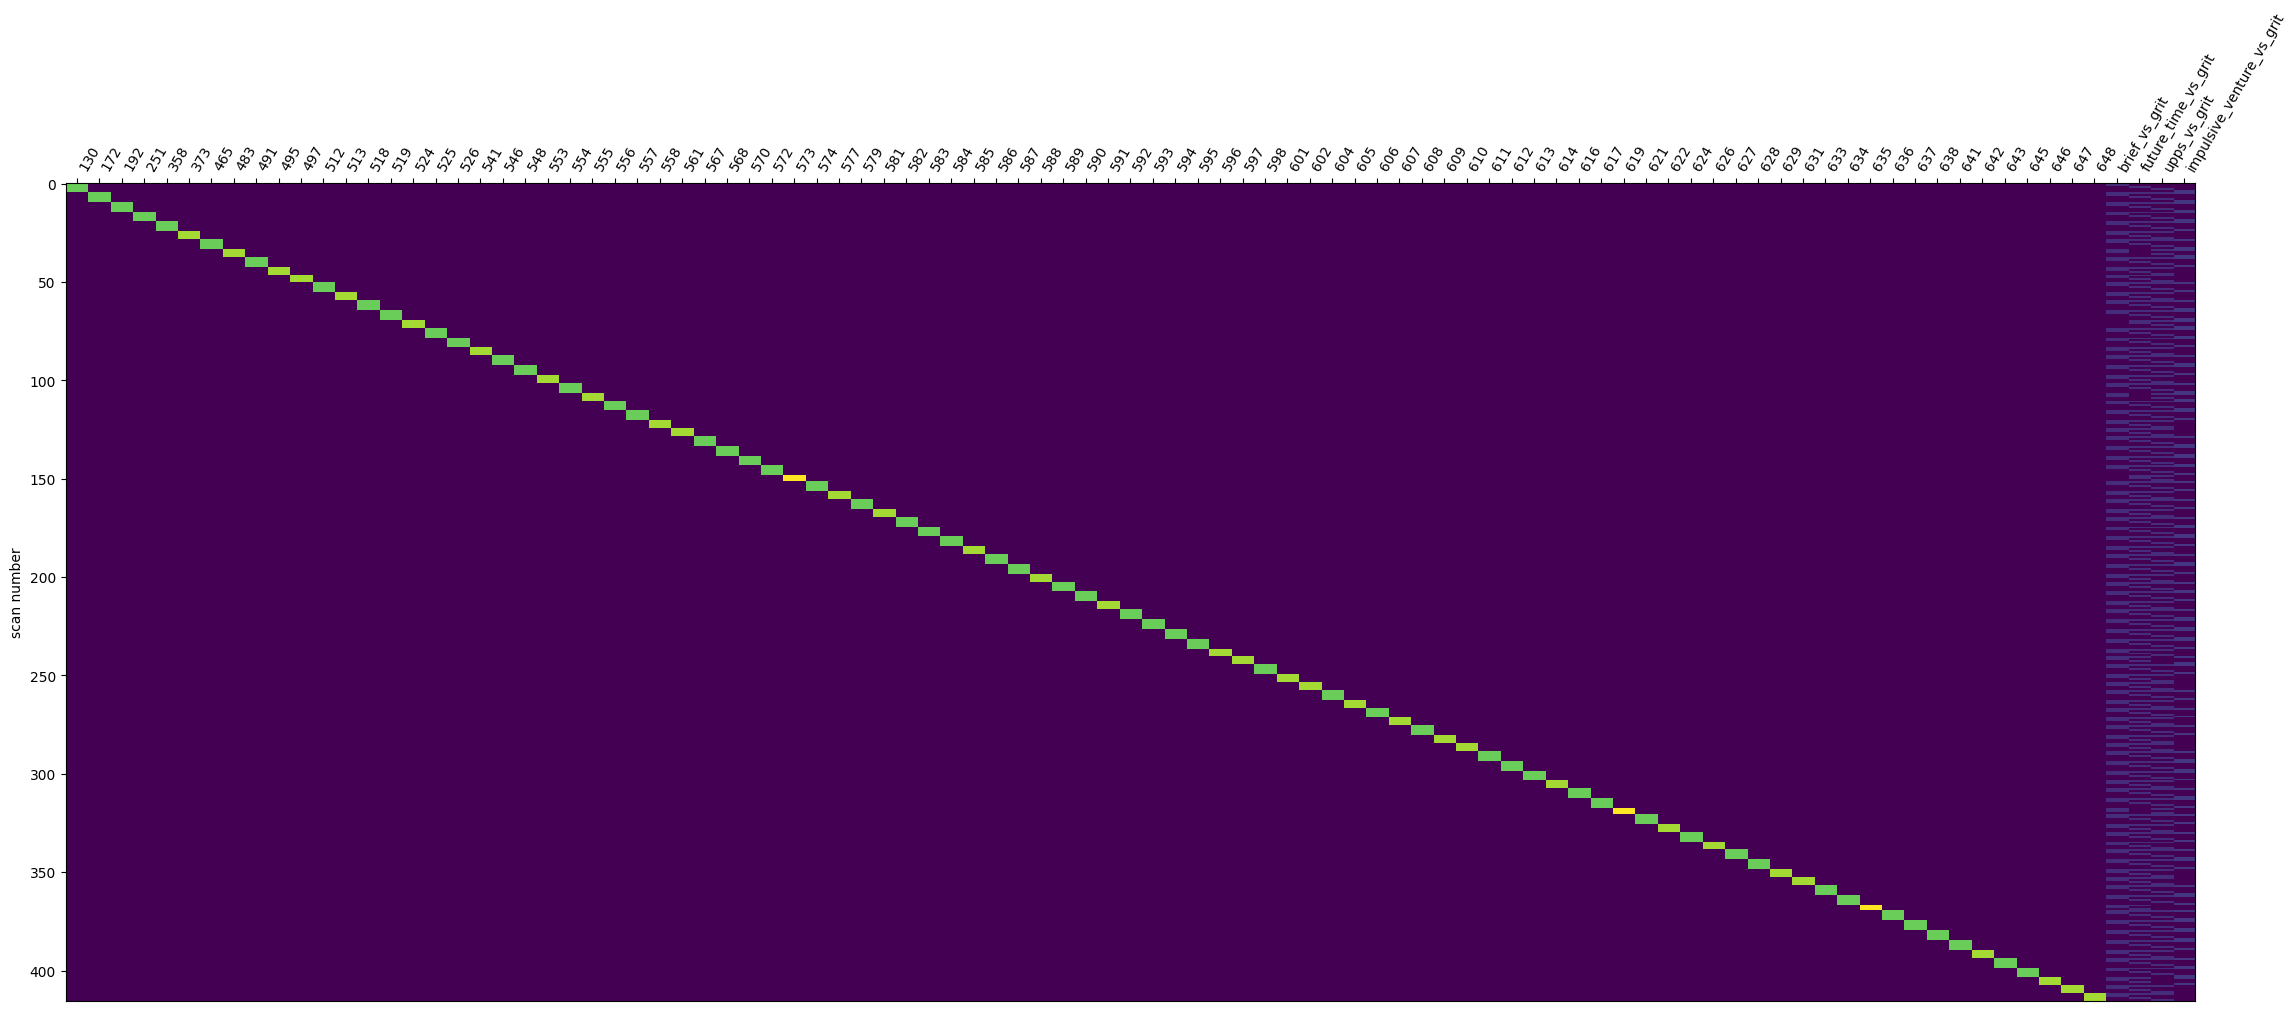

In [8]:
# outlier_file = pd.read_csv(
#     f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/behavioral_measures_effect_size_outlier_analysis/percent_outlier_data.csv'
# )

# contrast_estimates = []
# estimates_per_subject = {}  # keep track of which questionnaire contrasts each subject has
# subjects_to_remove = []  # we will remove subjects with no, or outlying, grit contrast, as this is our baseline questionnaire
# for sub_id in sub_ids:
#     sub_contrast_estimates = glob.glob(
#         f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/*behavioral_measures_effect_size_sub_{sub_id}*'
#     )
#     estimates_per_subject[sub_id] = []
#     for questionnaire in questionnaires:
#         contrast_present = False
#         filename = f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/{questionnaire}_behavioral_measures_effect_size_sub_{sub_id}.nii.gz'
#         if filename in sub_contrast_estimates:
#             # don't include contrast estimates past the outlier threshold: > 8% voxels above +/- 3SD above subject-specific mean
#             condition = (outlier_file['subject_label'] == int(sub_id)) & (
#                 outlier_file['contrast_name'] == questionnaire
#             )
#             outlier_percentage = outlier_file.loc[
#                 condition, 'image_outlier_percentage'
#             ].iloc[0]
#             if outlier_percentage > 8:
#                 if questionnaire == 'grit':
#                     subjects_to_remove.append(sub_id)
#                     break
#             else:
#                 contrast_estimates.append(filename)
#                 contrast_present = True
#         estimates_per_subject[sub_id].append(contrast_present)
# sub_ids = [sub for sub in sub_ids if sub not in subjects_to_remove]

# # Make group mask
# subject_masks = glob.glob(
#     f'{root}/derivatives/fmriprep/sub-s*/ses-['
#     f'0-9]/func/*surveyMedley*space-MNI152NLin2009cAsym*mask*.nii.gz'
# )
# subject_masks = [mask for mask in subject_masks if any(id in mask for id in sub_ids)]
# group_mask = masking.intersect_masks(subject_masks, threshold=.95)
# # nf.save(
# #     group_mask,
# #     f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/group_mask.nii.gz',
# # )

# # Create design matrix
# design_matrix = pd.DataFrame()
# # Add subject indicator regressors
# start = 0
# for sub_id in sub_ids:
#     one_indices = list(range(start, sum(estimates_per_subject[sub_id]) + start))
#     start = one_indices[-1] + 1
#     col = [1 if i in one_indices else 0 for i in range(len(contrast_estimates))]
#     design_matrix[sub_id] = col
# # Add questionnaire comparison regressors
# comparison_list = [
#     'brief_vs_grit',
#     'future_time_vs_grit',
#     'upps_vs_grit',
#     'impulsive_venture_vs_grit',
# ]
# for i in range(4):
#     col = []
#     for sub_id in sub_ids:
#         if (
#             (estimates_per_subject[sub_id][i + 1])
#             and (estimates_per_subject[sub_id][0])
#         ):
#             sub_one_indices = [
#                 1
#                 if (j == 0 or j == sum(estimates_per_subject[sub_id][: (i + 1)]))
#                 else 0
#                 for j in range(sum(estimates_per_subject[sub_id]))
#             ]
#         else:
#             sub_one_indices = [0 for j in range(sum(estimates_per_subject[sub_id]))]
#         col = col + sub_one_indices
#     design_matrix[comparison_list[i]] = col

# design_matrix_plot = plot_design_matrix(design_matrix)

In [10]:
unique_vals = {col: design_matrix[col].unique() for col in design_matrix.columns}
unique_vals

{'130': array([1, 0]),
 '172': array([0, 1]),
 '192': array([0, 1]),
 '251': array([0, 1]),
 '358': array([0, 1]),
 '373': array([0, 1]),
 '465': array([0, 1]),
 '483': array([0, 1]),
 '491': array([0, 1]),
 '495': array([0, 1]),
 '497': array([0, 1]),
 '512': array([0, 1]),
 '513': array([0, 1]),
 '518': array([0, 1]),
 '519': array([0, 1]),
 '524': array([0, 1]),
 '525': array([0, 1]),
 '526': array([0, 1]),
 '541': array([0, 1]),
 '546': array([0, 1]),
 '548': array([0, 1]),
 '553': array([0, 1]),
 '554': array([0, 1]),
 '555': array([0, 1]),
 '556': array([0, 1]),
 '557': array([0, 1]),
 '558': array([0, 1]),
 '561': array([0, 1]),
 '567': array([0, 1]),
 '568': array([0, 1]),
 '570': array([0, 1]),
 '572': array([0, 1]),
 '573': array([0, 1]),
 '574': array([0, 1]),
 '577': array([0, 1]),
 '579': array([0, 1]),
 '581': array([0, 1]),
 '582': array([0, 1]),
 '583': array([0, 1]),
 '584': array([0, 1]),
 '585': array([0, 1]),
 '586': array([0, 1]),
 '587': array([0, 1]),
 '588': arr

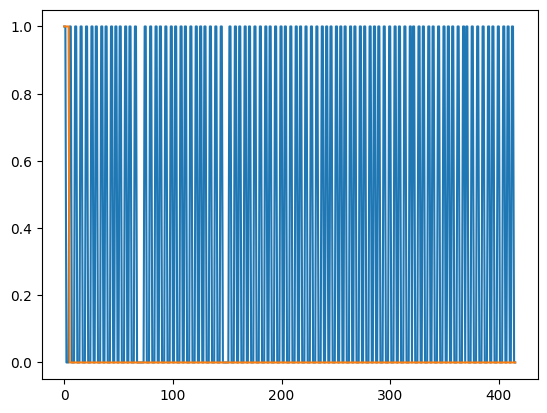

In [13]:
import matplotlib.pyplot as plt

plt.plot(design_matrix['brief_vs_grit'])
plt.plot(design_matrix['130'])
plt.show()

In [17]:
both_one = ((design_matrix['brief_vs_grit'] == 1) & (design_matrix['130'] == 1)).sum()
print(both_one)

2


In [19]:
design_matrix.loc[:6,]

,130,172,192,251,358,373,465,483,491,495,...,642,643,645,646,647,648,brief_vs_grit,future_time_vs_grit,upps_vs_grit,impulsive_venture_vs_grit
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


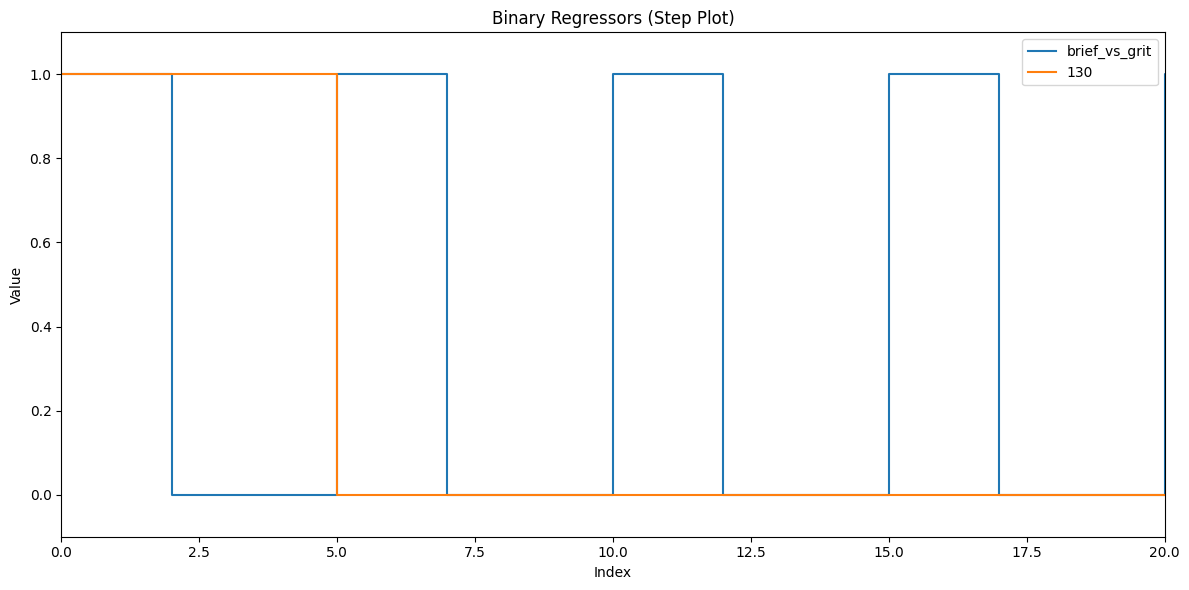

In [16]:
plt.figure(figsize=(12, 6))

# use step plots for binary regressors
plt.step(
    range(len(design_matrix)),
    design_matrix['brief_vs_grit'],
    where='post',
    label='brief_vs_grit',
)
plt.step(range(len(design_matrix)), design_matrix['130'], where='post', label='130')

plt.xlim(0, 20)
plt.ylim(-0.1, 1.1)  # optional, keeps binary regressors tidy
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Binary Regressors (Step Plot)')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
t_contrasts = {
    "brief_vs_grit": "brief_vs_grit",
    "future_time_vs_grit": "future_time_vs_grit",
    "upps_vs_grit": "upps_vs_grit",
    "impulsive_venture_vs_grit": "impulsive_venture_vs_grit"
}

f_test = {"omnibus_f": ["brief_vs_grit", "future_time_vs_grit", "upps_vs_grit", "impulsive_venture_vs_grit"]}

script_path = setup_randomise_tfce(
    input_files=contrast_estimates,
    group_mask='/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/group_mask.nii.gz',
    output_directory='/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/output_glm_ftest',
    analysis_type="glm",
    num_perm=5000,
    design_matrix=design_matrix,
    contrast=t_contrasts,
    ftest=f_test,
    rename_output=True
)

Concatenating input files...
Created 4D file: /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/output_glm_ftest/input_data4d.nii.gz


# Create design.grp file

In [7]:
grp_path = '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/output_glm_ftest/design.grp'
with open(grp_path, 'w') as f:
  f.write('/NumWaves  1\n')
  f.write(f'/NumPoints  {len(contrast_estimates)}\n')
  f.write('\n')
  f.write('/Matrix\n')
  group_membership = 1
  for sub in sub_ids:
    for i in range(sum(estimates_per_subject[sub])):
      f.write(f'{group_membership}\n')
    group_membership += 1
     

Before running the randomise_call.sh script, amend the randomise call that is created to include a flag -e design.grp.

# Plot figures

We can plot the F-stat map thresholded at p < 0.05, and compare this with the F-stat map from the F-test that used all 40 questions.

In [9]:
from nilearn import plotting
import numpy as np

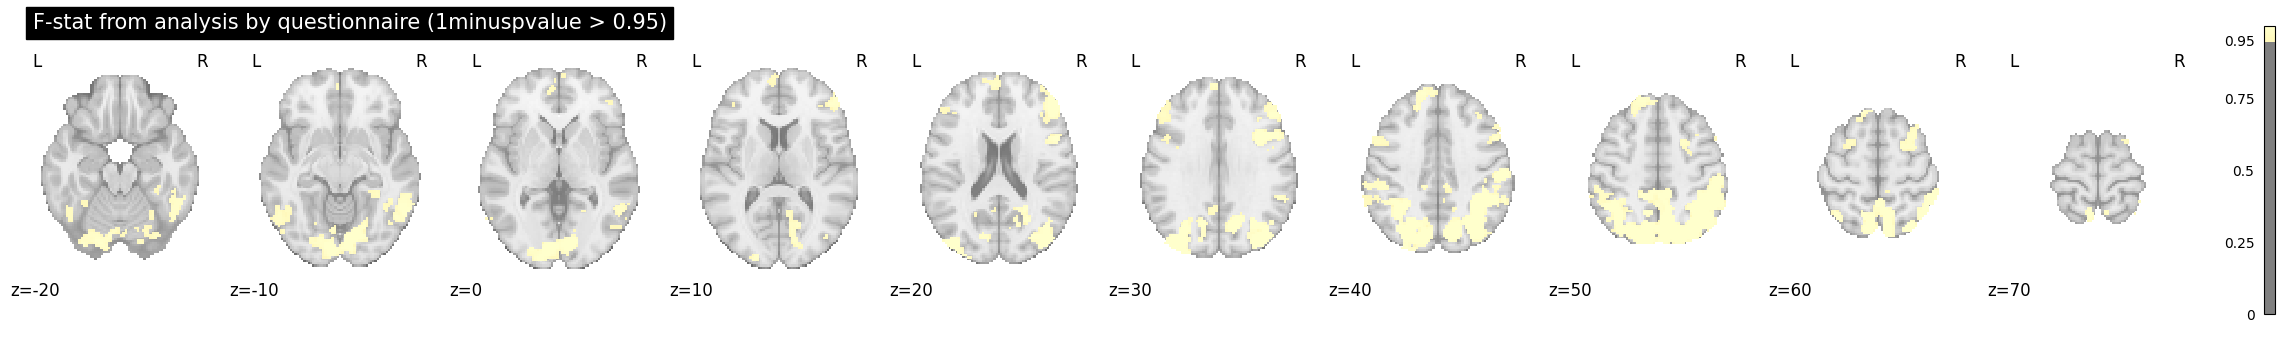

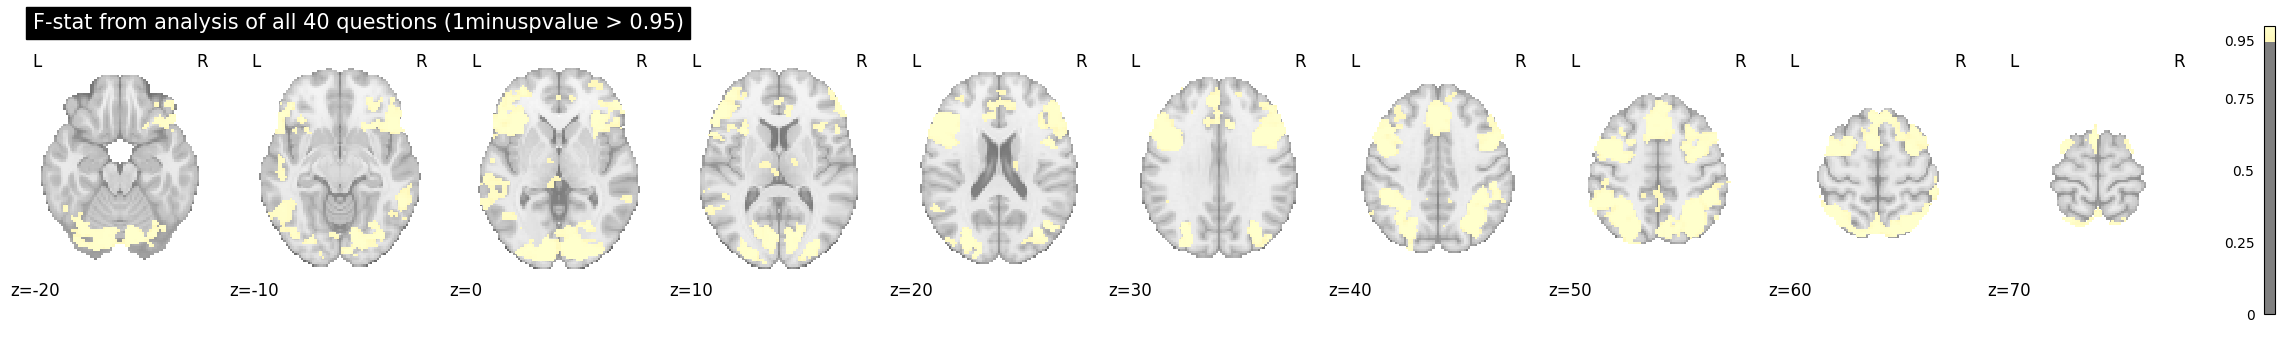

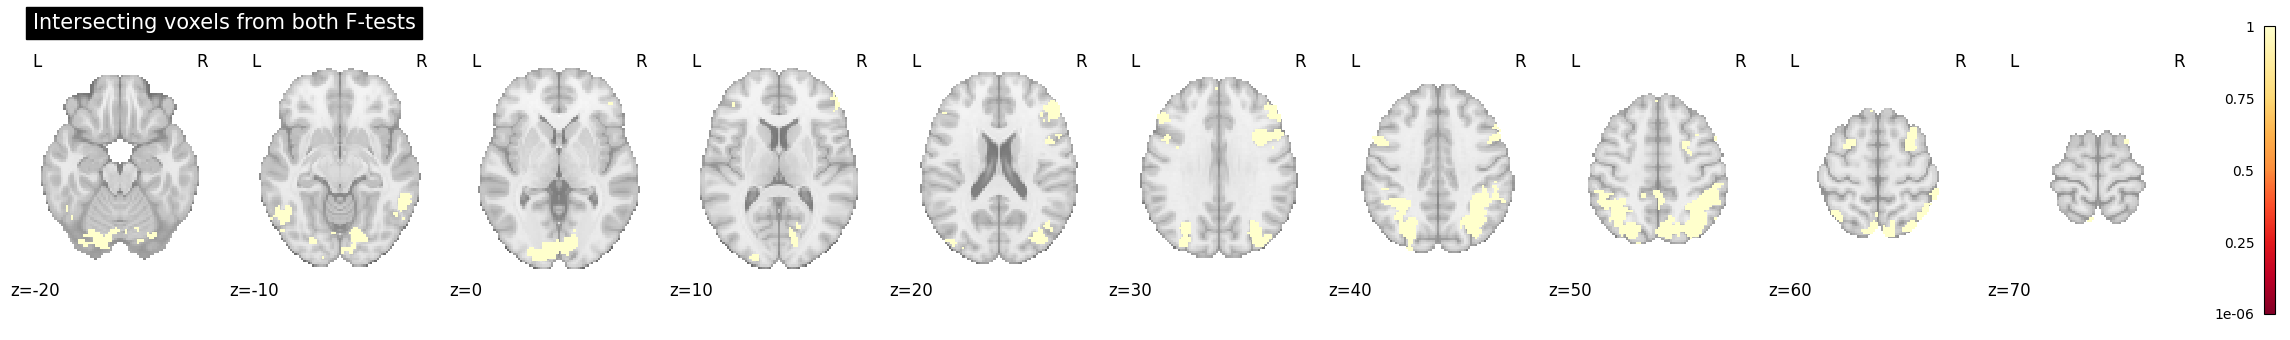

Overlap fraction: 0.234


In [12]:
z_slices = [-20, -10, 0, 10, 20, 30, 40, 50, 60, 70]
output_path = f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/output_glm_ftest'

# Plot F-stat p-value maps
fstat_pvalue_map = nf.load(f'{output_path}/glm_tfce_corrp_fstat1.nii.gz')
plotting.plot_stat_map(
            fstat_pvalue_map,
            display_mode='z',
            cut_coords=z_slices,
            colorbar=True,
            cmap='YlOrRd_r', 
            vmin=0, 
            vmax=1,
            threshold=0.95, 
            title=f'F-stat from analysis by questionnaire (1minuspvalue > 0.95)'
        )
plotting.show()

old_fstat_pvalue_map = nf.load(f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/output_twosided_onesample_t_test/onesample_2sided_tfce_corrp_fstat1.nii.gz')
plotting.plot_stat_map(
            old_fstat_pvalue_map,
            display_mode='z',
            cut_coords=z_slices,
            colorbar=True,
            cmap='YlOrRd_r', 
            vmin=0, 
            vmax=1,
            threshold=0.95, 
            title=f'F-stat from analysis of all 40 questions (1minuspvalue > 0.95)'
        )
plotting.show()

# Look at the overlap between the two maps
fstat_data = fstat_pvalue_map.get_fdata()
old_fstat_data = old_fstat_pvalue_map.get_fdata()

binary_fstat_data = (fstat_data > 0.95).astype(int)
binary_old_fstat_data = (old_fstat_data > 0.95).astype(int)
intersection = binary_fstat_data * binary_old_fstat_data
overlap_image = nf.Nifti1Image(intersection, fstat_pvalue_map.affine, fstat_pvalue_map.header)
plotting.plot_stat_map(
            overlap_image,
            display_mode='z',
            cut_coords=z_slices,
            colorbar=True,
            cmap='YlOrRd_r', 
            vmin=0, 
            vmax=1,
            title=f'Intersecting voxels from both F-tests'
        )
plotting.show()
overlap_fraction = np.sum(intersection) / np.sum((binary_fstat_data + binary_old_fstat_data) > 0)
print(f'Overlap fraction: {overlap_fraction:.3f}')

Also, try plotting the uncorrected t-stat maps

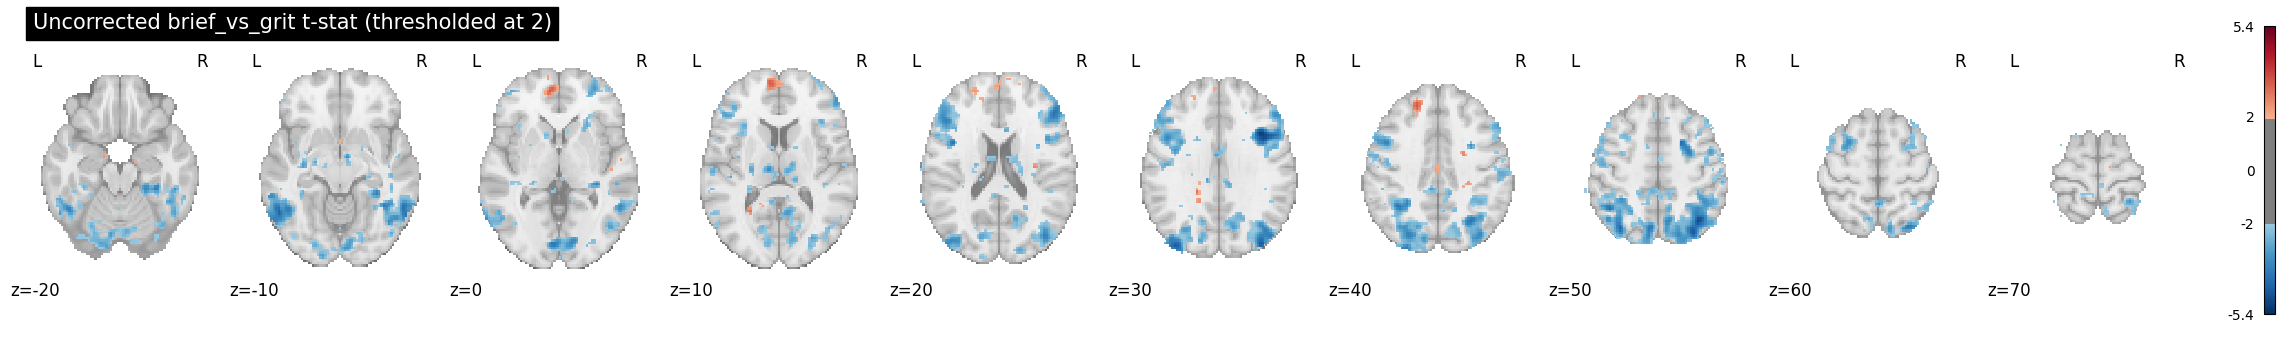

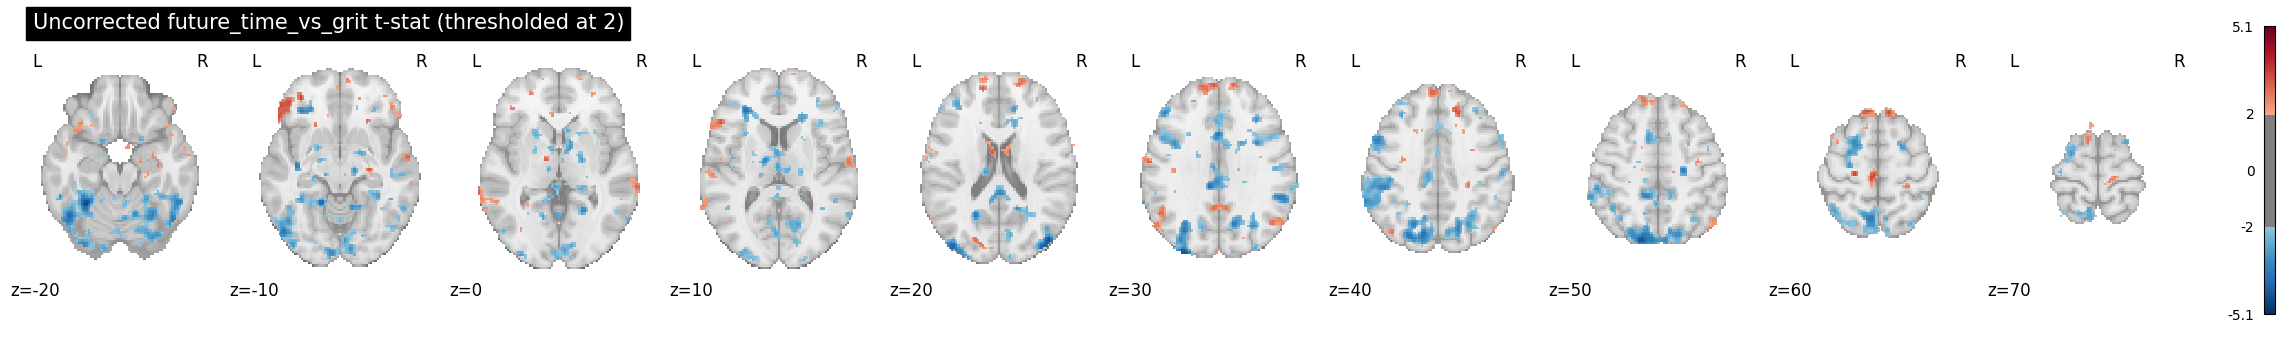

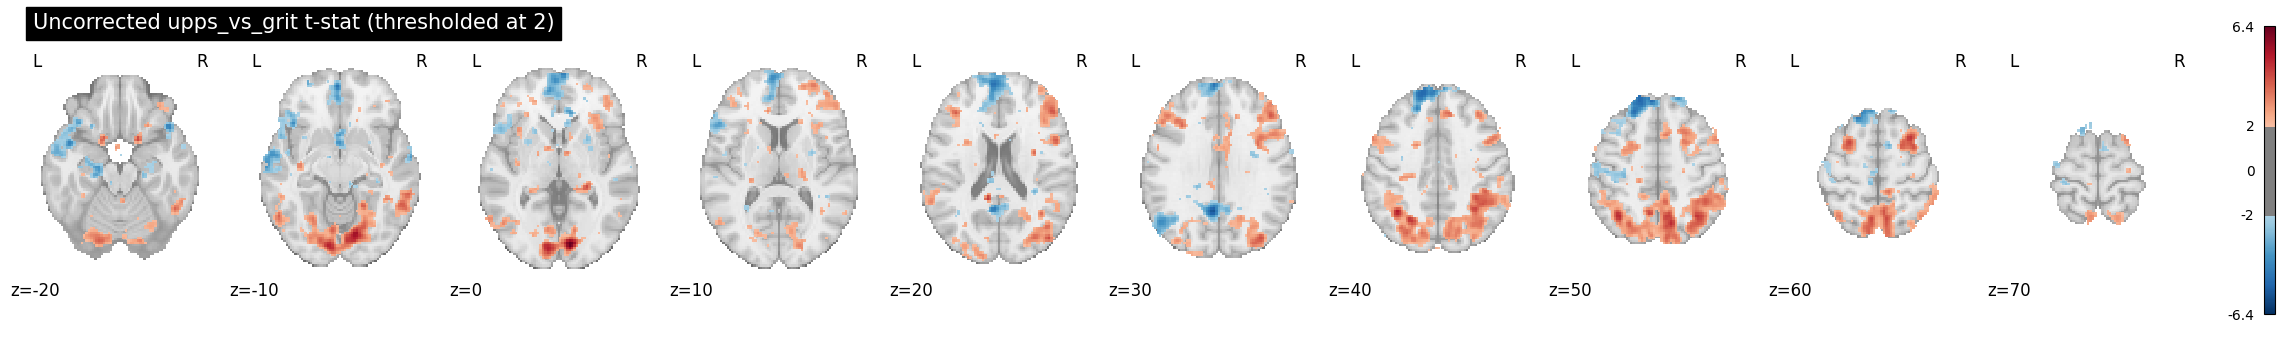

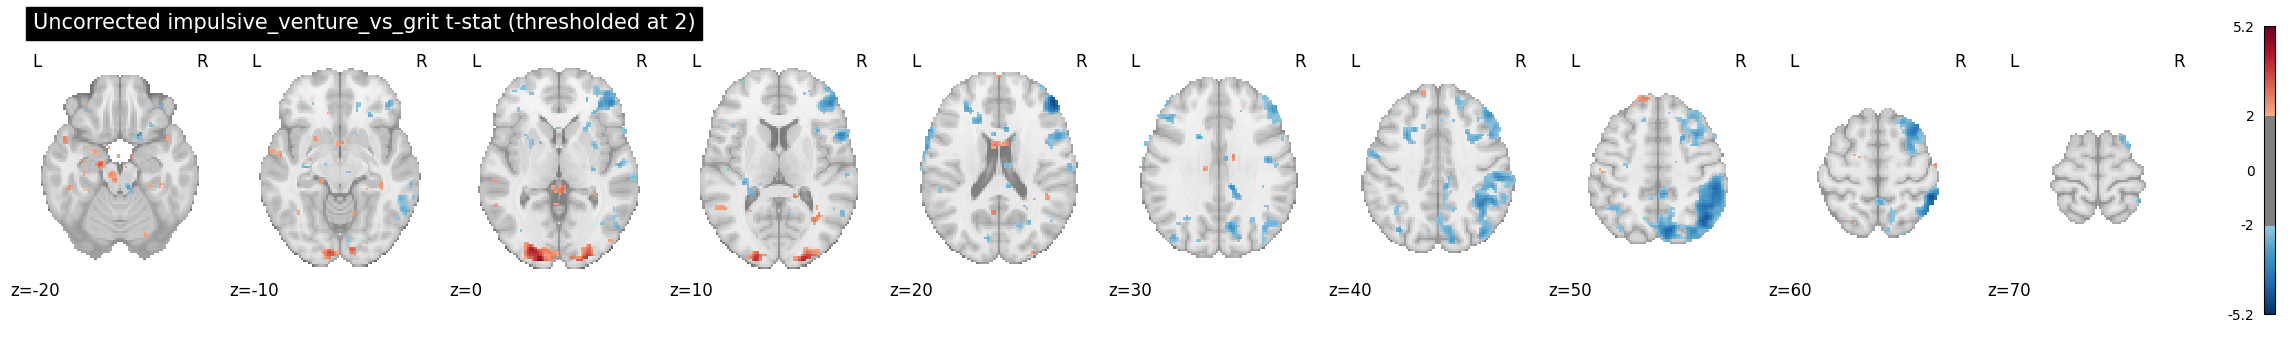

In [13]:
contrast_list = ['brief_vs_grit', 'future_time_vs_grit', 'upps_vs_grit', 'impulsive_venture_vs_grit']
for i in range(4):
  tstat_map = nf.load(f'{output_path}/glm_tstat{i + 1}.nii.gz')
  plotting.plot_stat_map(
            tstat_map,
            display_mode='z',
            cut_coords=z_slices,
            threshold=2.0, 
            colorbar=True,
            title=f'Uncorrected {contrast_list[i]} t-stat (thresholded at 2)'
        )
plotting.show()